# Project Objectives

The objective of this project is to analyze a publicly available ICU dataset from Kaggle to explore whether machine learning can provide clinical insights for critical care decision-making. Specifically, the project focuses on predicting patient outcome (surived or deceased) to support effective treatment to high risk patients and optimize resource allocation.

The ICU dataset presents typical of real-world clinical challenges, including sparsity, unbalanced outcome classes, missing values and limited feature dimensions. Through this project, we will:

1. Explore ICU clinical variables to understand their distributions and relationships.
2. Identify key features that most influence patient outcomes.
3. Assess the impact of missing data and implement strategies for imputation
4. Evaluate machine learning models for predictive performance and feasibility within healthcare constraints.

### Data Souce:
Dataset Link:
https://www.kaggle.com/datasets/fdemoribajolin/death-classification-icu

In [6]:
import warnings

warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import utility as util
import shap

## Load Data

In [7]:
X_train=pd.read_csv('./data/X_train_2025.csv')
Y_train=pd.read_csv('./data/y_train_2025.csv')

In [8]:
df=pd.concat([X_train,Y_train],axis=1)
df.head()

recordid  SAPS-I  SOFA   Age  Gender  Height  Weight  CCU  CSRU  SICU  ...  \
0    137517      -1     2  56.0     0.0     NaN    79.6    0     0     0  ...   
1    145680      10     3  72.0     1.0     NaN    70.0    0     0     0  ...   
2    138649      -1     8  81.0     0.0     NaN     NaN    0     0     0  ...   
3    149075      16     8  56.0     1.0   180.3    94.8    1     0     0  ...   
4    141408      14     7  52.0     1.0   182.9   120.6    0     1     0  ...   

   TroponinI_last  TroponinT_last  WBC_last  Weight_last  pH_last  \
0             NaN             NaN       7.3         79.6      NaN   
1             NaN            0.07       2.4         70.0     7.48   
2             NaN             NaN       7.0          NaN      NaN   
3             NaN             NaN      11.4         98.9     7.44   
4             NaN             NaN       9.0        120.6     7.43   

   MechVentStartTime  MechVentDuration  MechVentLast8Hour  UrineOutputSum  \
0                NaN               NaN                NaN             NaN   
1                NaN               NaN                NaN             NaN   
2                NaN               NaN                NaN             NaN   
3             1128.0             470.0                0.0             4.0   
4              143.0            2580.0                1.0            16.0   

   In-hospital_death  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  

[5 rows x 121 columns]

In [9]:
print('Number of rows:', df.shape[0])
print('Number of columns:', df.shape[1])

Number of rows: 3600
Number of columns: 121


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600 entries, 0 to 3599
Columns: 121 entries, recordid to In-hospital_death
dtypes: float64(114), int64(7)
memory usage: 3.3 MB


### Dataset Overview

This ICU dataset contains **3,600 patient records** with **121 features**:

- **recordid:** Unique identifier for each patient  
- **In-hospital_death:** Binary outcome indicating survival (`0`) or death (`1`)
- **Clinical features:** 119 columns with historical patient measurements, including vitals and laboratory results

# Data Exploratory Analysis

In [11]:
# Statistical summary
df.describe()

recordid       SAPS-I         SOFA          Age       Gender  \
count    3600.000000  3600.000000  3600.000000  3600.000000  3596.000000   
mean   140964.911389    14.187500     6.311111    64.462778     0.563126   
std      5583.521700     6.061105     4.191431    17.630796     0.496068   
min    132539.000000    -1.000000    -1.000000    15.000000     0.000000   
25%    136374.500000    11.000000     3.000000    53.000000     0.000000   
50%    140071.500000    15.000000     6.000000    67.000000     1.000000   
75%    145233.750000    18.000000     9.000000    78.000000     1.000000   
max    152851.000000    34.000000    22.000000    90.000000     1.000000   

             Height       Weight          CCU         CSRU         SICU  ...  \
count   1862.000000  3277.000000  3600.000000  3600.000000  3600.000000  ...   
mean     175.749198    81.729774     0.140556     0.213611     0.281944  ...   
std      256.371473    23.677343     0.347611     0.409912     0.450009  ...   
min      121.900000    36.500000     0.000000     0.000000     0.000000  ...   
25%      162.600000    66.000000     0.000000     0.000000     0.000000  ...   
50%      170.200000    79.000000     0.000000     0.000000     0.000000  ...   
75%      177.800000    92.000000     0.000000     0.000000     1.000000  ...   
max    11220.000000   280.000000     1.000000     1.000000     1.000000  ...   

       TroponinI_last  TroponinT_last     WBC_last  Weight_last      pH_last  \
count      175.000000      786.000000  3516.000000  2407.000000  2748.000000   
mean         6.714857        0.923537    12.361761    85.064769     7.399782   
std          9.643306        2.163239     6.309717    24.617355     0.060998   
min          0.300000        0.010000     1.000000    36.200000     7.030000   
25%          0.800000        0.040000     8.500000    68.300000     7.370000   
50%          1.700000        0.120000    11.300000    82.000000     7.410000   
75%          8.800000        0.567500    14.800000    97.400000     7.440000   
max         46.000000       19.700000   130.900000   280.000000     7.630000   

       MechVentStartTime  MechVentDuration  MechVentLast8Hour  UrineOutputSum  \
count        2264.000000        2264.00000        2264.000000     2264.000000   
mean          292.278269        1895.00530           0.617049       12.120141   
std           494.095873         876.76375           0.486214        5.818560   
min             0.000000           0.00000           0.000000        1.000000   
25%            52.000000        1140.00000           0.000000        7.000000   
50%           118.000000        2281.50000           1.000000       13.000000   
75%           241.000000        2670.00000           1.000000       16.000000   
max          2854.000000        2880.00000           1.000000       38.000000   

       In-hospital_death  
count        3600.000000  
mean            0.139722  
std             0.346747  
min             0.000000  
25%             0.000000  
50%             0.000000  
75%             0.000000  
max             1.000000  

[8 rows x 121 columns]

In [12]:
#Check if there are any duplicate rows
duplicate_check=df.duplicated().sum()
print('Number of duplicate rows:', duplicate_check)

Number of duplicate rows: 0


## Target Distribution

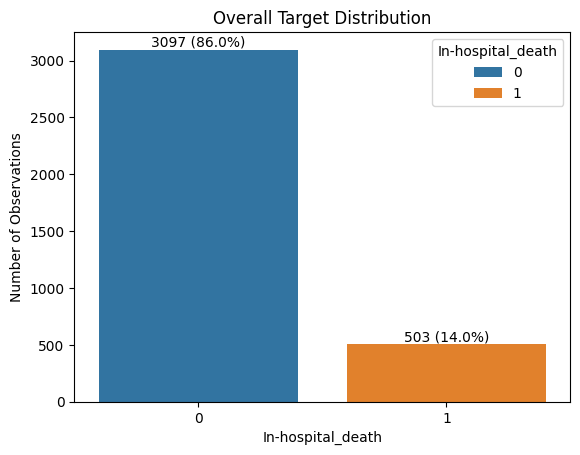

In [13]:
util.plot_target_distribution(df,'In-hospital_death', 'Overall Target Distribution')

## Features Distribution

In [14]:
numeric_cols=df.select_dtypes(include=['int64','float64']).columns.tolist()
# Exclude columns that contains the unique identifer, target label, binary flagging indicators, timestamp
columns_to_exclude=['recordid','In-hospital_death','CCU','CSRU','SICU','Gender','MechVentLast8Hour','MechVentStartTime']
for column in columns_to_exclude:
  numeric_cols.remove(column)
numeric_cols.sort()

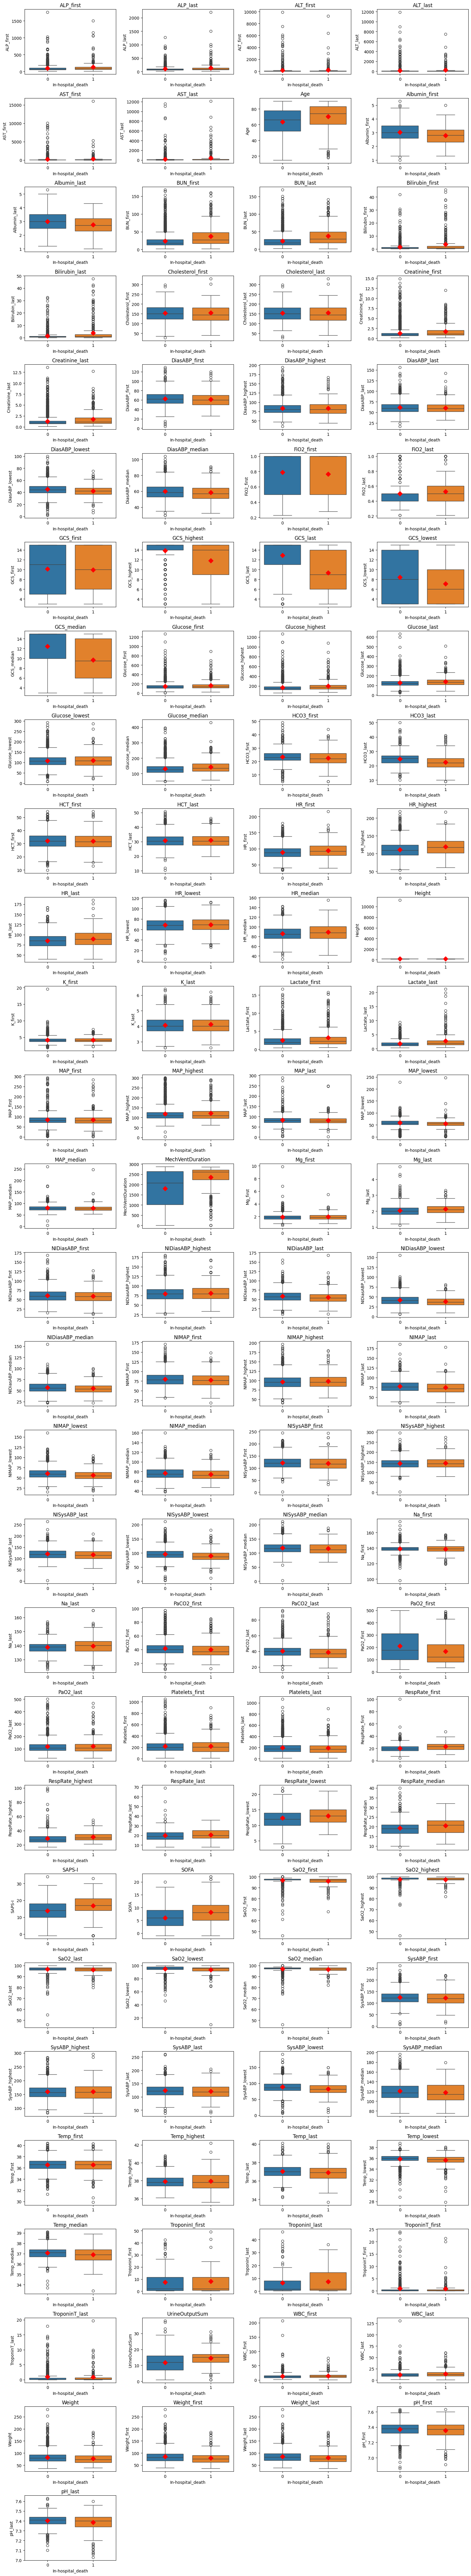

In [15]:
#Raw numeric features distribution
util.plot_boxplots(df, numeric_cols, 'In-hospital_death')

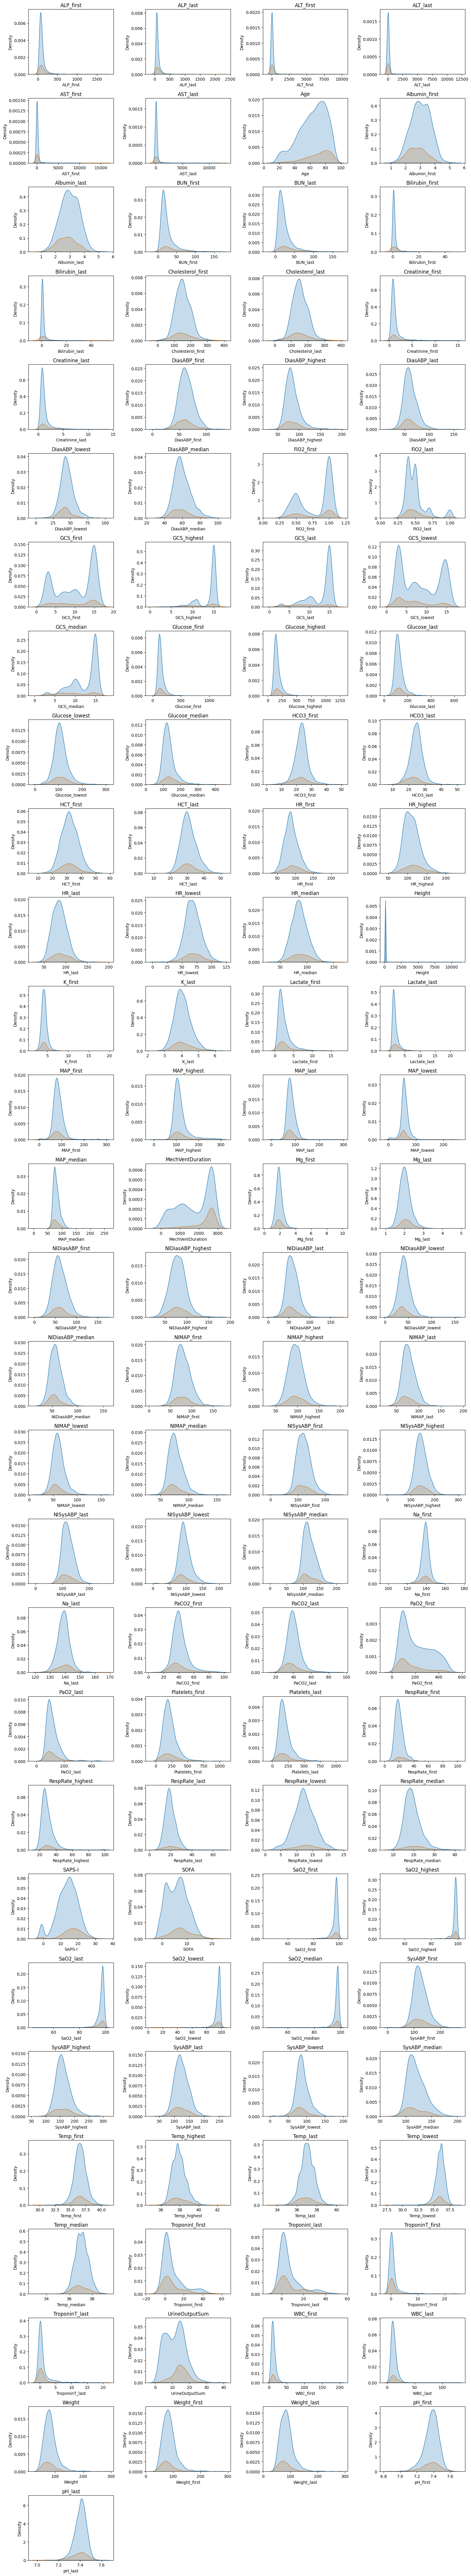

In [16]:
# Plot KDE plots for raw numeric features
util.plot_kde_plots(df, numeric_cols, 'In-hospital_death')

### Distribution Analysis

The target distribution is highly imbalanced, with **14% dead cases** and **86% survival cases**.

Raw numeric features show substantial overlap between survival (`0`) and non-survival (`1`) patients, as observed in both boxplots and Kernel Density Estimation (KDE) plots. This overlap indicates that individual raw features may have limited discriminative power when considered independently.

Several variables also contain extreme outliers. While some of these values may reflect rare but valid clinical observations, others are likely due to data entry errors. For example, recorded heights exceeding 1,000 units when the population mean is approximately 175 units.


## Missing Data

In [17]:
missing_summary_df=pd.DataFrame({
    '# Missing': df.isnull().sum(),
    '% Missing': df.isnull().mean()*100}).sort_values(by='# Missing', ascending=False)
print('Top 20 missing data columns:', missing_summary_df.head(20))

Top 20 missing data columns:                    # Missing  % Missing
TroponinI_first         3425  95.138889
TroponinI_last          3425  95.138889
Cholesterol_last        3325  92.361111
Cholesterol_first       3325  92.361111
TroponinT_first         2814  78.166667
TroponinT_last          2814  78.166667
RespRate_highest        2606  72.388889
RespRate_lowest         2606  72.388889
RespRate_first          2606  72.388889
RespRate_last           2606  72.388889
RespRate_median         2606  72.388889
Albumin_first           2128  59.111111
Albumin_last            2128  59.111111
ALP_first               2068  57.444444
ALP_last                2068  57.444444
Bilirubin_last          2041  56.694444
ALT_last                2041  56.694444
Bilirubin_first         2041  56.694444
ALT_first               2041  56.694444
AST_first               2038  56.611111


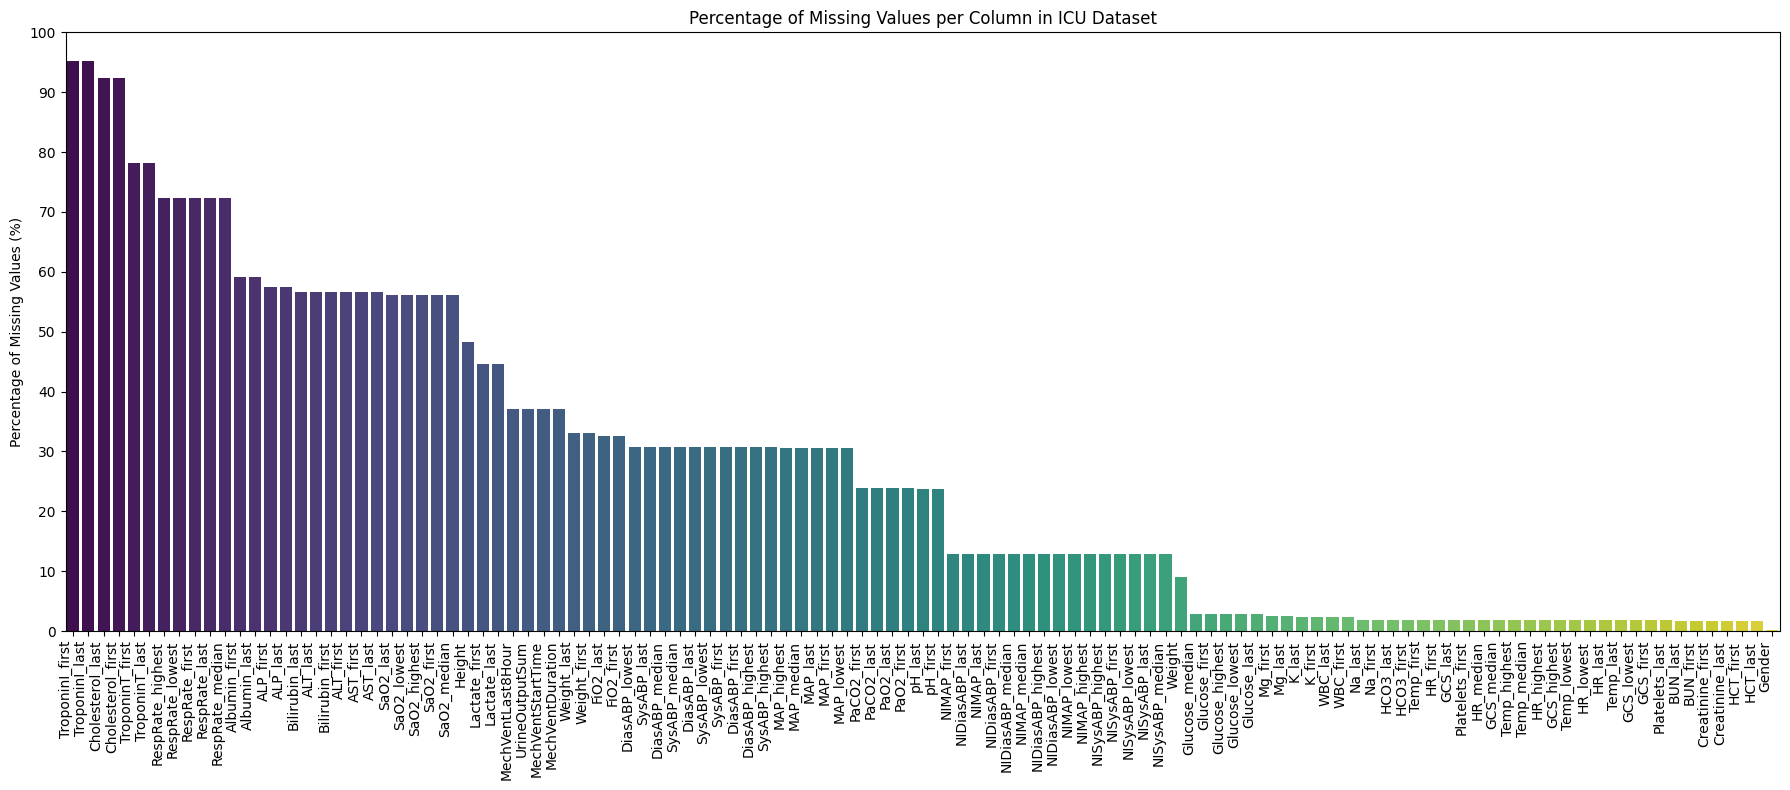

In [18]:
# Filter columns that have at least one missing value
missing_pct = missing_summary_df[missing_summary_df['% Missing'] > 0]

# Plot Missing Data Distribution
plt.figure(figsize=(18,8))
sns.barplot(x=missing_pct.index, y=missing_pct['% Missing'], palette='viridis')
plt.xticks(rotation=90, ha='right')
plt.ylabel('Percentage of Missing Values (%)')
plt.xlabel('')
plt.title('Percentage of Missing Values per Column in ICU Dataset')
plt.ylim(0, 100)
plt.yticks(range(0,101,10))
plt.tight_layout()
plt.show()


## Data Cleaning

- `Heights` > 250 units fall outside commonly accepted human ranges and are considered implausible, likely due to data entry or measurement errors. Rather than removing the affected records, these values are set to `NaN` to indicate missing measurements and to preserve the underlying patient observations.

- `MechVentStartTime` represents the timestamp when mechanical ventilation was initiated. However, in the dataset, the raw values are inconsistent and difficult to interpret (e.g., 0, 117, 2809). This feature is excluded for downstream analysis and modeling.




In [19]:
# 99th percentile in Height
df.Height.quantile(0.99)

np.float64(193.0)

In [20]:
# Patient with height value >250 are like measuring 
df[df.Height>250][['recordid','Age','Height','Weight','In-hospital_death']]

recordid   Age   Height  Weight  In-hospital_death
167     140620  81.0    308.0    97.3                  0
177     142140  82.0    286.0    94.1                  0
1217    136967  88.0    301.4    99.3                  0
3229    147129  63.0  11220.0    57.9                  0

In [21]:
# Set unrealist height values >250 to NaN
df_clean=df.copy()
df_clean.loc[df_clean.Height>250, 'Height'] = np.nan

#Summary statistics after cleaning
df_clean[['Height']].describe()

Height
count  1858.000000
mean    169.606893
std      11.024440
min     121.900000
25%     162.600000
50%     170.200000
75%     177.800000
max     208.300000

In [22]:
df_clean=df_clean.drop(columns=['MechVentStartTime'],axis=1)  #Drop this column due to inconsistent and difficult to interpret

## Data Split

The dataset is divided using a **70/30 split**, with **70% of the data used for training** and **30% reserved for testing**.

In [23]:
X=df_clean.drop(columns=['recordid','In-hospital_death'],axis=1)
y=df_clean['In-hospital_death']

X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

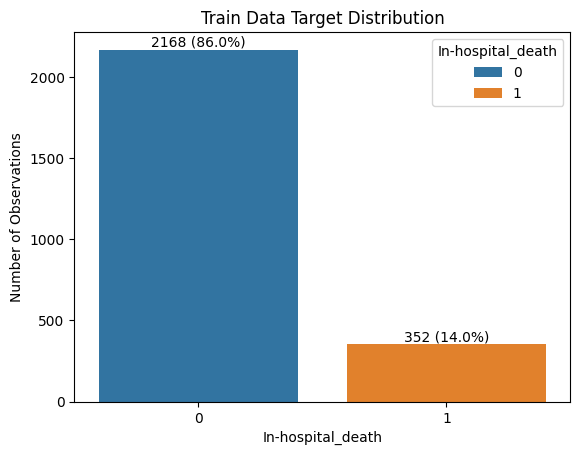

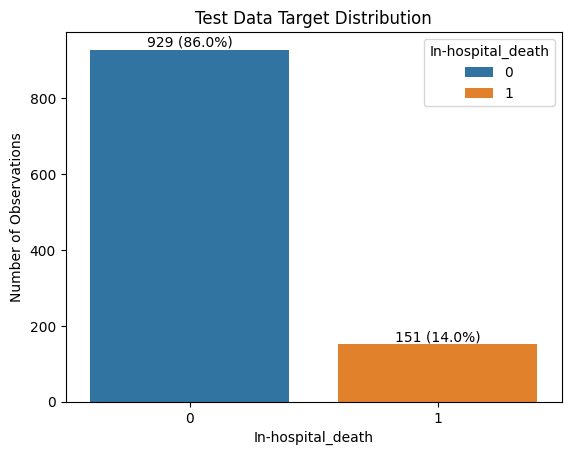

In [24]:
util.plot_target_distribution(y_train,'In-hospital_death', 'Train Data Target Distribution')
util.plot_target_distribution(y_test,'In-hospital_death', 'Test Data Target Distribution')

## Data Impuation

Because clinical tests in the ICU are ordered based on patient-specific conditions, missing data may reflect clinical decision-making rather than data quality issues and can carry predictive signal for patient outcomes. Based on this understanding, the following imputation guidelines are applied:

* Features with >= 20% missing data include a binary indicator flag denoting whether the test was performed (1) or not performed (0).
* Features with > 70% missing data are dropped due to insufficient observations, particularly among the minority non-survival class.
* Features with < 70% missing data are imputed using clinically appropriate values such as the median, mode, or patient-specific historical measurements.

In [25]:
missing_pct_70=missing_pct[missing_pct['% Missing']>70] #Features with >70% missing
missing_pct_gt20=missing_pct[(missing_pct['% Missing']>=20) & (missing_pct['% Missing']<=70)] #Features with 20-70% missing
missing_pct_lt20=missing_pct[missing_pct['% Missing']<20] #Features with <20% missing
missing_pct=missing_pct[missing_pct['% Missing']>0] #Features with any missing values 

In [26]:
median_imputer_cols=missing_pct.index.tolist()
median_imputer_cols.remove('MechVentStartTime')

In [27]:
#Compute median value for imputation from training data
median_values = X_train[median_imputer_cols].median()

### Features missing >70%

* Troponin
* Cholesterol
* Respiratory Rate

In [28]:
# Features with >70% missing values
missing_pct_70=missing_pct[missing_pct['% Missing']>70]
print(missing_pct_70)

                   # Missing  % Missing
TroponinI_first         3425  95.138889
TroponinI_last          3425  95.138889
Cholesterol_last        3325  92.361111
Cholesterol_first       3325  92.361111
TroponinT_first         2814  78.166667
TroponinT_last          2814  78.166667
RespRate_highest        2606  72.388889
RespRate_lowest         2606  72.388889
RespRate_first          2606  72.388889
RespRate_last           2606  72.388889
RespRate_median         2606  72.388889


In [29]:
#Check if TroponinI or TroponinT was tested
Troponin_cols=['TroponinI_first','TroponinI_last','TroponinT_first','TroponinT_last']
troponin_measured = df[df[Troponin_cols].notnull().any(axis=1)][Troponin_cols]
print(f"Number of records Troponin was tested: {len(troponin_measured)}")

#Check if both TroponinI and TroponinT were tested
troponin_both_measured = X_train[
    df[['TroponinI_first','TroponinI_last']].notnull().any(axis=1) &
    df[['TroponinT_first','TroponinT_last']].notnull().any(axis=1)][Troponin_cols]

print(f"Number of records both TroponinI and TroponinT were tested: {len(troponin_both_measured)}")

Number of records Troponin was tested: 961
Number of records both TroponinI and TroponinT were tested: 0


In [30]:
#Apply Flagging indicator for Troponin and remove original columns
X_train=util.create_measured_flag(X_train, Troponin_cols, 'Troponin_tested', True)
X_test=util.create_measured_flag(X_test, Troponin_cols, 'Troponin_tested', True)

#Check Distribution
print(X_train['Troponin_tested'].value_counts())
print(X_test['Troponin_tested'].value_counts())

Troponin_tested
0    1835
1     685
Name: count, dtype: int64
Troponin_tested
0    804
1    276
Name: count, dtype: int64


In [31]:
#Apply flagging indicator for the Cholestrole and remove original volumns
chol_cols=['Cholesterol_first','Cholesterol_last']
X_train=util.create_measured_flag(X_train, chol_cols, 'Cholesterol_tested', True)
X_test=util.create_measured_flag(X_test, chol_cols, 'Cholesterol_tested', True)

print(X_train['Cholesterol_tested'].value_counts())
print(X_test['Cholesterol_tested'].value_counts())

Cholesterol_tested
0    2322
1     198
Name: count, dtype: int64
Cholesterol_tested
0    1003
1      77
Name: count, dtype: int64


In [32]:
#Apply flagging indicator for the Respiration Rate
resp_rate_cols=['RespRate_last','RespRate_highest','RespRate_lowest','RespRate_first','RespRate_median']
X_train=util.create_measured_flag(X_train, resp_rate_cols, 'RespRate_tested', True)
X_test=util.create_measured_flag(X_test, resp_rate_cols, 'RespRate_tested', True)

print(X_train['RespRate_tested'].value_counts())
print(X_test['RespRate_tested'].value_counts())

RespRate_tested
0    1805
1     715
Name: count, dtype: int64
RespRate_tested
0    801
1    279
Name: count, dtype: int64


### Features missing 20% to 70%

In [33]:
print(missing_pct_gt20.index.sort_values())

Index(['ALP_first', 'ALP_last', 'ALT_first', 'ALT_last', 'AST_first',
       'AST_last', 'Albumin_first', 'Albumin_last', 'Bilirubin_first',
       'Bilirubin_last', 'DiasABP_first', 'DiasABP_highest', 'DiasABP_last',
       'DiasABP_lowest', 'DiasABP_median', 'FiO2_first', 'FiO2_last', 'Height',
       'Lactate_first', 'Lactate_last', 'MAP_first', 'MAP_highest', 'MAP_last',
       'MAP_lowest', 'MAP_median', 'MechVentDuration', 'MechVentLast8Hour',
       'MechVentStartTime', 'PaCO2_first', 'PaCO2_last', 'PaO2_first',
       'PaO2_last', 'SaO2_first', 'SaO2_highest', 'SaO2_last', 'SaO2_lowest',
       'SaO2_median', 'SysABP_first', 'SysABP_highest', 'SysABP_last',
       'SysABP_lowest', 'SysABP_median', 'UrineOutputSum', 'Weight_first',
       'Weight_last', 'pH_first', 'pH_last'],
      dtype='object')


In [34]:
# Add binary flagging indicator
ALP_cols=['ALP_first','ALP_last']
X_train=util.create_measured_flag(X_train, ALP_cols, 'ALP_tested', False)
X_test=util.create_measured_flag(X_test, ALP_cols, 'ALP_tested', False) 

ALT_cols=['ALT_first','ALT_last']
X_train=util.create_measured_flag(X_train, ALT_cols, 'ALT_tested', False)
X_test=util.create_measured_flag(X_test, ALT_cols, 'ALT_tested', False)

AST_cols=['AST_first','AST_last']
X_train=util.create_measured_flag(X_train, AST_cols, 'AST_tested',False)
X_test=util.create_measured_flag(X_test, AST_cols, 'AST_tested',False)

Albumin_cols=['Albumin_first','Albumin_last']
X_train=util.create_measured_flag(X_train, Albumin_cols, 'Albumin_tested',False)
X_test=util.create_measured_flag(X_test, Albumin_cols, 'Albumin_tested',False)  

Bilirubin_cols=['Bilirubin_first','Bilirubin_last']
X_train=util.create_measured_flag(X_train, Bilirubin_cols, 'Bilirubin_tested',False)
X_test=util.create_measured_flag(X_test, Bilirubin_cols, 'Bilirubin_tested',False)

DiasABP_cols=['DiasABP_first','DiasABP_last','DiasABP_highest','DiasABP_lowest','DiasABP_median']
X_train=util.create_measured_flag(X_train, DiasABP_cols, 'DiasABP_tested',False)
X_test=util.create_measured_flag(X_test, DiasABP_cols, 'DiasABP_tested',False)

FiO2_cols=['FiO2_first','FiO2_last']
X_train=util.create_measured_flag(X_train, FiO2_cols, 'FiO2_tested',False)
X_test=util.create_measured_flag(X_test, FiO2_cols, 'FiO2_tested',False)

X_train=util.create_measured_flag(X_train, ['Height'], 'Height_tested',False)
X_test=util.create_measured_flag(X_test, ['Height'], 'Height_tested',False)

Lactate_cols=['Lactate_first','Lactate_last']
X_train=util.create_measured_flag(X_train, Lactate_cols, 'Lactate_tested',False)
X_test=util.create_measured_flag(X_test, Lactate_cols, 'Lactate_tested',False)

MAP_cols=['MAP_first','MAP_last','MAP_highest','MAP_lowest','MAP_median']
X_train=util.create_measured_flag(X_train, MAP_cols, 'MAP_tested',False)
X_test=util.create_measured_flag(X_test, MAP_cols, 'MAP_tested',False)

MechVent_cols=['MechVentDuration','MechVentLast8Hour']
X_train=util.create_measured_flag(X_train, MechVent_cols, 'MechVent_tested',False)
X_test=util.create_measured_flag(X_test, MechVent_cols, 'MechVent_tested',False)

SaO2_cols=['SaO2_first','SaO2_last','SaO2_highest','SaO2_lowest','SaO2_median']
X_train=util.create_measured_flag(X_train, SaO2_cols, 'SaO2_tested',False)
X_test=util.create_measured_flag(X_test, SaO2_cols, 'SaO2_tested',False)

SysABP_cols=['SysABP_first','SysABP_last','SysABP_highest','SysABP_lowest','SysABP_median']
X_train=util.create_measured_flag(X_train, SysABP_cols, 'SysABP_tested',False)
X_test=util.create_measured_flag(X_test, SysABP_cols, 'SysABP_tested',False)    

X_train=util.create_measured_flag(X_train, ['UrineOutputSum'], 'UrineOutput_tested',False)
X_test=util.create_measured_flag(X_test, ['UrineOutputSum'], 'UrineOutput_tested',False)

Weight_cols=['Weight_first','Weight_last']
X_train=util.create_measured_flag(X_train, Weight_cols, 'Weight_tested',False)
X_test=util.create_measured_flag(X_test, Weight_cols, 'Weight_tested',False)

In [35]:
# Fill in median values for imputation except for weights
cols_to_impute_gt20 = missing_pct_gt20.index.difference(['Weight_first', 'Weight_last'])
for col in cols_to_impute_gt20:
    #if col != 'MechVentStartTime':
    X_train[col].fillna(median_values[col], inplace=True)
    X_test[col].fillna(median_values[col], inplace=True)   

KeyError: 'MechVentStartTime'

In [ ]:
#Check the numbers with missing values in weights
print(df_clean[['Weight_first','Weight_last','Weight']].isnull().sum())

Weight_first    1193
Weight_last     1193
Weight           323
dtype: int64


In [ ]:
# Check the records with any missing values in weights
df_clean[df_clean[['Weight_first','Weight_last','Weight']].isnull().any(axis=1)][['recordid','Weight_first','Weight_last','Weight','In-hospital_death']]

recordid  Weight_first  Weight_last  Weight  In-hospital_death
2       138649           NaN          NaN     NaN                  0
5       150941           NaN          NaN    96.5                  0
6       132584           NaN          NaN    72.8                  0
7       136768           NaN          NaN    75.0                  0
9       149549           NaN          NaN   112.0                  0
...        ...           ...          ...     ...                ...
3581    136941           NaN          NaN    81.8                  0
3584    140001           NaN          NaN    60.0                  1
3585    141936           NaN          NaN    70.0                  0
3594    135631           NaN          NaN    75.0                  0
3599    139102           NaN          NaN     NaN                  0

[1219 rows x 5 columns]

In [ ]:
# Fill missing values with historical measurements for Weights
def fill_weight(x_data):

    #Fill weight first and weight last with historical weight
    x_data['Weight_first']=x_data['Weight_first'].fillna(x_data['Weight'])
    x_data['Weight_last']=x_data['Weight_last'].fillna(x_data['Weight'])

    #Fill weight with first weight
    x_data['Weight']=x_data['Weight'].fillna(x_data['Weight_last'])
    
    return x_data
X_train=fill_weight(X_train)
X_test=fill_weight(X_test)  

In [ ]:
# Fill in median values for imputation Weights
for col in ['Weight_first', 'Weight_last', 'Weight']:
    X_train[col].fillna(median_values[col], inplace=True)
    X_test[col].fillna(median_values[col], inplace=True)

### Features missing <20%

In [ ]:
print(missing_pct_lt20.index.sort_values())

Index(['BUN_first', 'BUN_last', 'Creatinine_first', 'Creatinine_last',
       'GCS_first', 'GCS_highest', 'GCS_last', 'GCS_lowest', 'GCS_median',
       'Gender', 'Glucose_first', 'Glucose_highest', 'Glucose_last',
       'Glucose_lowest', 'Glucose_median', 'HCO3_first', 'HCO3_last',
       'HCT_first', 'HCT_last', 'HR_first', 'HR_highest', 'HR_last',
       'HR_lowest', 'HR_median', 'K_first', 'K_last', 'Mg_first', 'Mg_last',
       'NIDiasABP_first', 'NIDiasABP_highest', 'NIDiasABP_last',
       'NIDiasABP_lowest', 'NIDiasABP_median', 'NIMAP_first', 'NIMAP_highest',
       'NIMAP_last', 'NIMAP_lowest', 'NIMAP_median', 'NISysABP_first',
       'NISysABP_highest', 'NISysABP_last', 'NISysABP_lowest',
       'NISysABP_median', 'Na_first', 'Na_last', 'Platelets_first',
       'Platelets_last', 'Temp_first', 'Temp_highest', 'Temp_last',
       'Temp_lowest', 'Temp_median', 'WBC_first', 'WBC_last', 'Weight'],
      dtype='object')


In [ ]:
# Features to fill in with median values
cols_to_impute_lt20 = missing_pct_lt20.index.difference(['Gender', 'Weight'])
for col in cols_to_impute_lt20:
    X_train[col].fillna(median_values[col], inplace=True)
    X_test[col].fillna(median_values[col], inplace=True)

In [ ]:
# Gender to fill in with mode value
Gender_mode=X_train['Gender'].mode()[0]

X_train['Gender'].fillna(Gender_mode, inplace=True)
X_test['Gender'].fillna(Gender_mode, inplace=True)

In [ ]:
# Verify no missing values remain
print('Missing values in X_train after imputation:', X_train.isnull().sum().sum())
print('Missing values in X_test after imputation:', X_test.isnull().sum().sum())

Missing values in X_train after imputation: 0
Missing values in X_test after imputation: 0


## Univariate Statistical Feature Assessment

Exploratory visualization using boxplots and KDE plots indicated that most numeric features are not normally distributed. 
To quantify the discriminative power of each feature, the following statistical tests are applied:

- **Numeric features**: Mann–Whitney U test with effect size to assess whether the distributions differ between the survival and non-survival groups.
- **Binary features and missingness indicators**: Fisher’s exact test and Odds Ratio to evaluate association with outcome.



In [ ]:
train_df=pd.concat([X_train, y_train], axis=1)

In [ ]:
# Get the binary flagging indicator columns
binary_cols = [col for col in train_df.columns if col.endswith('_tested')] + ['Gender','CCU','CSRU','SICU','MechVentLast8Hour']

# Get the numeric columns after imputation
numeric_cols_after_imputation = [col for col in train_df.select_dtypes(include=['int64','float64']).columns.tolist() if col not in binary_cols + ['In-hospital_death']]

### Mann-Whitney U and Effect Size on Numeric Features

Objective: Assess whether the distributions of numeric features differ between the survival and non-survival groups.

**Null Hypothesis (H₀):** The distribution of a feature is the same between the survival and non-survival groups.  
**Alternative Hypothesis (H₁):** The distribution of a feature differs between the survival and non-survival groups.

Effect size is quantified using the **rank-biserial correlation **, measures the magnitude of the distributional difference:
- Effect Size < 0.1: Negligible effect
- Effect Size > 0.1 to 0.3: Small effect
- Effect Size > 0.3 to 0.5: Medium effect
- Effect size > 0.5: Large effect

In [ ]:
#Call the mann_whitney_u_test function
mann_whitney_u_test_df=util.mann_whitney_u_test(train_df, outcome_col='In-hospital_death', numeric_cols=numeric_cols_after_imputation)

# Sort by p-value and filter significant features
mann_whitney_u_test_df=mann_whitney_u_test_df.sort_values(by='p-value', ascending=True)

# Add effect size interpretation
mann_whitney_u_test_df['Effect Size Interpretation'] = mann_whitney_u_test_df['Effect Size Abs'].apply(util.interpret_effect_size)

In [ ]:
# Numeric Features with no significant difference
NoSignificantEffect=mann_whitney_u_test_df[mann_whitney_u_test_df['p-value']>=0.05].index.tolist()

In [ ]:
# Numeric Features with no significant difference
NoSignificant_Features=mann_whitney_u_test_df[mann_whitney_u_test_df['p-value']>=0.05]
NoSignificant_Features

U-statistic   p-value  Median Survived  \
Feature                                                     
Platelets_last        406146.0  0.052246           176.00   
HR_median             357069.0  0.052974            86.00   
pH_first              405300.5  0.058071             7.38   
SysABP_median         405043.5  0.058946           117.00   
SaO2_first            400129.0  0.061559            98.00   
GCS_first             403929.0  0.067670            11.00   
NIMAP_first           403405.5  0.084153            78.00   
NISysABP_first        402995.5  0.090103           120.00   
SysABP_last           401094.0  0.116580           121.00   
DiasABP_first         399315.0  0.152720            61.00   
DiasABP_last          398817.0  0.164742            60.00   
FiO2_last             369924.5  0.310469             0.50   
MAP_last              394065.5  0.314651            81.00   
ALT_last              370409.5  0.326759            30.00   
Mg_first              369518.5  0.339657             1.90   
MAP_highest           370126.5  0.357529           110.00   
Platelets_first       392702.5  0.379213           199.00   
HCT_first             391449.0  0.435182            32.00   
SysABP_highest        372249.0  0.453536           157.00   
Height                390055.5  0.467670           170.20   
HR_lowest             372619.5  0.479628            68.00   
Na_first              390431.0  0.482462           139.00   
ALT_first             375733.5  0.608043            30.00   
PaO2_last             387189.0  0.654542           106.00   
Glucose_lowest        376857.5  0.709875           107.00   
K_last                376963.5  0.715510             4.00   
NISysABP_highest      377438.0  0.743916           142.00   
NIDiasABP_highest     379208.0  0.851902            79.00   
NIMAP_highest         379371.0  0.862092            96.00   
SysABP_first          383115.0  0.901018           122.00   
MAP_first             383083.5  0.903041            82.00   
Temp_highest          380266.5  0.918069            37.80   
DiasABP_highest       380364.5  0.922884            81.00   
K_first               382742.0  0.926059             4.10   
Temp_first            381030.5  0.966149            36.60   
HCT_last              381385.5  0.988531            30.40   

                   Median Non-Survived  Effect Size  Effect Size Abs  \
Feature                                                                
Platelets_last                  173.00    -0.064413         0.064413   
HR_median                        88.00     0.064206         0.064206   
pH_first                          7.38    -0.062197         0.062197   
SysABP_median                   117.00    -0.061524         0.061524   
SaO2_first                       98.00    -0.048644         0.048644   
GCS_first                        10.00    -0.058603         0.058603   
NIMAP_first                      78.00    -0.057231         0.057231   
NISysABP_first                  120.00    -0.056156         0.056156   
SysABP_last                     121.00    -0.051173         0.051173   
DiasABP_first                    61.00    -0.046511         0.046511   
DiasABP_last                     60.00    -0.045206         0.045206   
FiO2_last                         0.50     0.030515         0.030515   
MAP_last                         81.00    -0.032753         0.032753   
ALT_last                         30.00     0.029244         0.029244   
Mg_first                          1.90     0.031579         0.031579   
MAP_highest                     110.00     0.029985         0.029985   
Platelets_first                 199.50    -0.029181         0.029181   
HCT_first                        31.90    -0.025896         0.025896   
SysABP_highest                  157.00     0.024423         0.024423   
Height                          170.20    -0.022244         0.022244   
HR_lowest                        68.00     0.023452         0.023452   
Na_first                        139.00    -0

In [ ]:
# Numeric Features with Significant Difference
Significant_Feartures=mann_whitney_u_test_df[mann_whitney_u_test_df['p-value']<0.05]

In [ ]:
# Significant Features with Small to Large Effect Size
Significant_Features_EffectSize=Significant_Feartures[Significant_Feartures['Effect Size Abs']>=0.1]
Significant_Features_EffectSize

U-statistic       p-value  Median Survived  \
Feature                                                        
GCS_last             576039.5  2.028120e-63            15.00   
GCS_highest          521244.5  4.316604e-42            15.00   
GCS_median           539542.5  2.641439e-39            14.50   
BUN_last             252440.0  1.930013e-24            18.00   
SAPS-I               262899.5  6.222239e-21            14.00   
MechVentDuration     266492.0  9.199508e-21          2280.00   
HCO3_last            498720.5  1.641543e-20            24.00   
BUN_first            268169.0  3.234641e-19            18.00   
UrineOutputSum       274680.5  1.777510e-18            13.00   
SOFA                 277217.5  1.418768e-16             6.00   
Lactate_last         294949.0  3.835419e-13             1.60   
Age                  290998.5  8.406611e-13            66.00   
PaCO2_last           461176.5  1.951047e-10            39.00   
NISysABP_lowest      460013.5  5.404155e-10            93.00   
Creatinine_last      303377.0  5.850328e-10             0.90   
Creatinine_first     303620.0  6.556437e-10             0.90   
Glucose_highest      305697.5  2.068721e-09           152.00   
NIMAP_lowest         452272.0  2.220521e-08            59.00   
Albumin_first        440986.0  6.739952e-08             3.00   
HR_highest           314749.5  1.307470e-07           109.00   
Weight_last          446549.0  2.841644e-07            82.40   
GCS_lowest           444805.0  3.120603e-07             8.00   
Glucose_last         317714.5  4.574769e-07           121.00   
NIDiasABP_lowest     445053.0  5.037687e-07            40.00   
Mg_last              320060.0  1.012887e-06             2.00   
Weight_first         443011.0  1.210047e-06            81.15   
PaO2_first           442035.0  1.494244e-06           165.00   
Glucose_median       321452.0  2.053992e-06           127.00   
MAP_lowest           440088.5  2.391886e-06            58.00   
PaCO2_first          439634.0  3.450742e-06            40.00   
WBC_last             323207.5  4.039409e-06            11.30   
NIDiasABP_last       439681.5  4.255276e-06            56.00   
DiasABP_lowest       438440.5  4.271984e-06            44.00   
Temp_lowest          438078.0  7.870774e-06            36.00   
NIMAP_last           437763.0  8.812154e-06            76.00   
NIDiasABP_median     435332.5  2.091009e-05            56.00   
Weight               432791.0  5.189171e-05            79.00   
Temp_median          432599.0  5.502216e-05            37.00   
Lactate_first        334393.5  8.095720e-05             1.90   
SysABP_lowest        430174.5  9.579634e-05            85.50   
Bilirubin_last       337855.0  9.616723e-05             0.70   
ALP_first            337470.0  1.018122e-04            77.00   
Bilirubin_first      338420.0  1.030669e-04             0.60   
Albumin_last         423762.0  1.350967e-04             2.90   
HCO3_first           429066.0  1.678004e-04            23.00   
ALP_last             338954.5  1.796144e-04            76.50   
NIMAP_median         428595.0  2.005810e-04            74.83   
WBC_first            334982.5  2.338554e-04            11.80   
HR_first             339203.0  8.180768e-04            88.00   
Temp_last            423566.5  8.983636e-04            37.00   
NISysABP_last        422033.5  1.369938e-03           118.00   
NISysABP_median      420508.5  2.070870e-03           115.00   

                  Median Non-Survived  Effect Size  Effect Size Abs  \
Feature                                                               
GCS_last                        9.000    -0.509664         0.509664   
GCS_highest                    13.000    -0.366059         0.366059   
GCS_median                      9.000    -0.414014         0.414014   
BUN_last                       27.500     0.338414         0.338414   
SAPS-I                         17.000     0.311002         0.311002   
MechVentDuration             2400.000     0.301587         0.301

In [ ]:
# Significant Features with Neg Effect Size
Significant_Features_NegEffect=Significant_Feartures[Significant_Feartures['Effect Size Abs']<0.1]
Significant_Features_NegEffect

U-statistic   p-value  Median Survived  Median Non-Survived  \
Feature                                                                        
FiO2_first          412854.5  0.002288             1.00                 1.00   
Na_last             344266.0  0.003126           139.00               140.00   
AST_last            348447.0  0.003703            42.00                42.00   
SaO2_highest        408595.5  0.005922            98.00                98.00   
Glucose_first       350036.5  0.012761           132.00               137.00   
SaO2_last           407299.0  0.016144            97.00                97.00   
DiasABP_median      410824.5  0.018741            58.50                58.50   
HR_last             352332.0  0.020922            85.00                87.00   
NIDiasABP_first     410597.5  0.021623            59.00                59.00   
pH_last             408550.0  0.030599             7.41                 7.41   
SaO2_median         405764.5  0.031897            97.50                97.50   
SaO2_lowest         405346.0  0.032250            96.00                96.00   
MAP_median          406055.5  0.048792            78.00                78.00   
AST_first           359147.0  0.049932            44.50                44.50   

                 Effect Size  Effect Size Abs Effect Size Interpretation  
Feature                                                                   
FiO2_first         -0.081995         0.081995                 Negligible  
Na_last             0.097760         0.097760                 Negligible  
AST_last            0.086802         0.086802                 Negligible  
SaO2_highest       -0.070833         0.070833                 Negligible  
Glucose_first       0.082637         0.082637                 Negligible  
SaO2_last          -0.067435         0.067435                 Negligible  
DiasABP_median     -0.076674         0.076674                 Negligible  
HR_last             0.076621         0.076621                 Negligible  
NIDiasABP_first    -0.076079         0.076079                 Negligible  
pH_last            -0.070713         0.070713                 Negligible  
SaO2_median        -0.063413         0.063413                 Negligible  
SaO2_lowest        -0.062317         0.062317                 Negligible  
MAP_median         -0.064176         0.064176                 Negligible  
AST_first           0.058760         0.058760                 Negligible

### Fisher's Exact Test and Odds Ratio on Binary Features

Objective: Assess the association between binary features and ICU outcome.

- **Null Hypothesis (H₀)**: The binary feature is independent of the ICU outcome.
- **Alternative Hypthesis (H₁)**: The binary feature is associated with the ICU outcome.

Effect size is reported using the **odds ratio (OR)**, which represents the magnitude and direction of association:
- OR between 0.8 and 1.2: Negligible association with the outcome  
- OR > 1.2: Increased odds of the adverse outcome  
- OR < 0.8: Decreased odds of the adverse outcome

In [ ]:
#Call the fisher_exact_test function
fisher_exact_test_df=util.fisher_exact_test(train_df, 'In-hospital_death', binary_cols)
fisher_exact_test_df=fisher_exact_test_df.sort_values(by='p-value', ascending=True)

fisher_exact_test_df['Odds Ratio Interpretation'] = fisher_exact_test_df['Odds Ratio'].apply(util.interpret_odds_ratio)

In [ ]:
binary_cols

['Troponin_tested',
 'Cholesterol_tested',
 'RespRate_tested',
 'ALP_tested',
 'ALT_tested',
 'AST_tested',
 'Albumin_tested',
 'Bilirubin_tested',
 'DiasABP_tested',
 'FiO2_tested',
 'Height_tested',
 'Lactate_tested',
 'MAP_tested',
 'MechVent_tested',
 'SaO2_tested',
 'SysABP_tested',
 'UrineOutput_tested',
 'Weight_tested',
 'Gender',
 'CCU',
 'CSRU',
 'SICU',
 'MechVentLast8Hour']

In [ ]:
# Features with Significant Difference
fisher_exact_test_df_significant=fisher_exact_test_df[fisher_exact_test_df['p-value']<0.05]
print('Number of binary features with significant difference:', fisher_exact_test_df_significant.shape[0])
fisher_exact_test_df_significant

Number of binary features with significant difference: 15


Odds Ratio       p-value Odds Ratio Interpretation
Feature                                                               
MechVentLast8Hour     5.556258  4.729782e-21      Positive Association
CSRU                  0.194345  1.238136e-17      Negative Association
Troponin_tested       2.431664  2.324182e-13      Positive Association
Lactate_tested        2.299756  6.779751e-12      Positive Association
ALT_tested            2.224087  7.460524e-12      Positive Association
AST_tested            2.211331  8.081909e-12      Positive Association
Bilirubin_tested      2.176996  2.614702e-11      Positive Association
ALP_tested            2.125118  7.994666e-11      Positive Association
FiO2_tested           2.204494  6.218094e-09      Positive Association
RespRate_tested       0.464122  7.172053e-08      Negative Association
Albumin_tested        1.863089  8.187238e-08      Positive Association
MechVent_tested       1.744669  8.189871e-06      Positive Association
UrineOutput_tested    1.744669  8.189871e-06      Positive Association
Height_tested         0.690081  1.546071e-03      Negative Association
MAP_tested            1.300505  4.120693e-02      Positive Association

In [ ]:
#Call the fisher_exact_test function
fisher_exact_test_df=util.fisher_exact_test(train_df, 'In-hospital_death', binary_cols)

In [ ]:
# Featuress with No Significant Difference
fisher_exact_test_df_no_significant=fisher_exact_test_df[fisher_exact_test_df['p-value']>=0.05]
fisher_exact_test_df_no_significant

Odds Ratio   p-value
Feature                                 
Cholesterol_tested    1.109139  0.594209
DiasABP_tested        1.271571  0.063715
SaO2_tested           1.020176  0.862229
SysABP_tested         1.271571  0.063715
Weight_tested         1.178130  0.200188
Gender                0.975513  0.862376
CCU                   0.970768  0.933325
SICU                  1.120254  0.373806

### Statistical Feature Assessment Summary

Univariate statistical tests were performed to evaluate the association between individual features and ICU outcome.

For numeric features, the Mann–Whitney U test was applied due to non-normal feature distributions, together with the rank-biserial effect size to quantify the magnitude of distributional differences. Fifty-two (52) numeric features rejected the null hypothesis, showing statistically significant differences between the survival and non-survival groups with small to large effect sizes, suggesting potential discriminative value. Fourteen (14) numeric features did not reject the null hypothesis and demonstrated negligible effect sizes, indicating limited standalone discriminative power.

For binary features, Fisher’s exact test was used to assess association with ICU outcome. Fifteen (15) binary features rejected the null hypothesis, indicating statistically significant associations with the outcome. Among these, twelve (12) features were associated with increased odds of adverse outcome, while three (3) features were associated with reduced odds, suggesting potential protective effects. The remaining eight (8) binary features did not reject the null hypothesis, with most (6) showing negligible effect sizes and a small number (2) exhibiting borderline effects.

Features with weak or non-significant univariate effects were retained for baseline modeling, as ICU outcomes are often driven by the combined and interactive effects of multiple variables rather than strong univariate signals alone.



# Baseline Models

## Linear Regression Model

In [ ]:
# Features scaling
scaler = StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)


# Add the feature names back to scaled data
X_train_scaled_df=pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df=pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [ ]:
# Logistic Model with L1 Regularization
logreg_l1 = LogisticRegression(penalty='l1', solver='liblinear', random_state=42, class_weight='balanced',max_iter=1000)
logreg_l1.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, penalty='l1',
                   random_state=42, solver='liblinear')

In [ ]:
# Predictions
y_prob_test=logreg_l1.predict_proba(X_test_scaled)[:,1]

In [ ]:
print('Number of iterations:', logreg_l1.n_iter_[0])

Number of iterations: 17


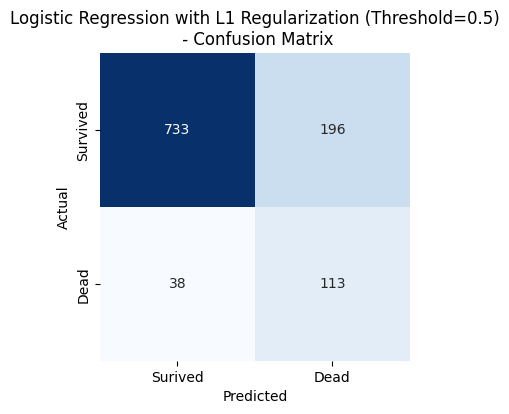

              precision    recall  f1-score   support

           0       0.95      0.79      0.86       929
           1       0.37      0.75      0.49       151

    accuracy                           0.78      1080
   macro avg       0.66      0.77      0.68      1080
weighted avg       0.87      0.78      0.81      1080



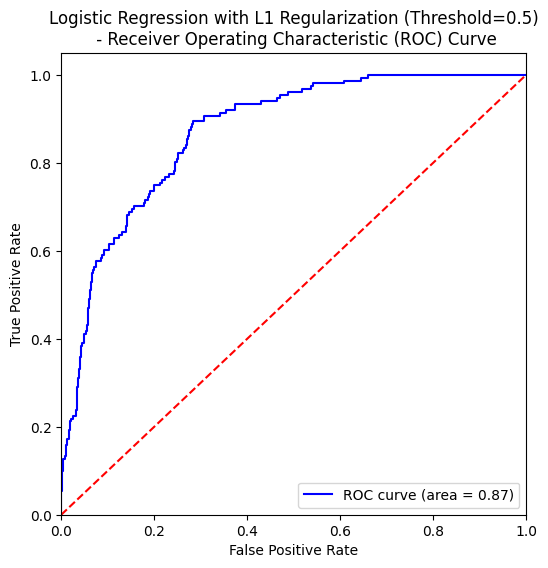

In [ ]:
util.evaluate_classification_model(y_prob_test, 0.5, y_test, model_name='Logistic Regression with L1 Regularization')

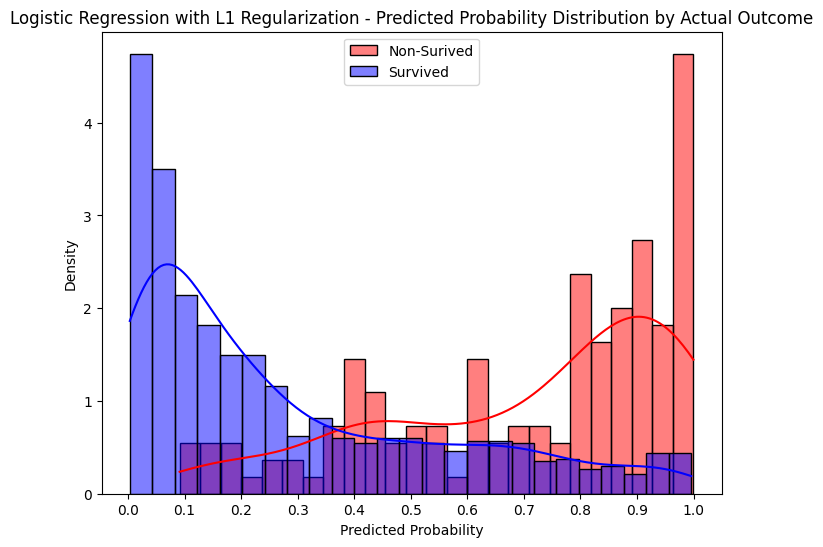

In [ ]:
# Visualize Threshold Distribution
util.plot_threshold_distribution(y_prob_test, y_test, model_name='Logistic Regression with L1 Regularization')

In [ ]:
util.threshold_analysis(y_prob_test, y_test, threshold_range=np.arange(0.3, 0.7, 0.01))

Threshold 0.300 -> Recall: 0.907, FPR: 0.336, Precisinon: 0.305
Threshold 0.310 -> Recall: 0.907, FPR: 0.332, Precisinon: 0.308
Threshold 0.320 -> Recall: 0.907, FPR: 0.326, Precisinon: 0.311
Threshold 0.330 -> Recall: 0.907, FPR: 0.321, Precisinon: 0.315
Threshold 0.340 -> Recall: 0.907, FPR: 0.312, Precisinon: 0.321
Threshold 0.350 -> Recall: 0.894, FPR: 0.306, Precisinon: 0.322
Threshold 0.360 -> Recall: 0.894, FPR: 0.294, Precisinon: 0.331
Threshold 0.370 -> Recall: 0.894, FPR: 0.284, Precisinon: 0.338
Threshold 0.380 -> Recall: 0.881, FPR: 0.281, Precisinon: 0.338
Threshold 0.390 -> Recall: 0.868, FPR: 0.276, Precisinon: 0.339
Threshold 0.400 -> Recall: 0.848, FPR: 0.270, Precisinon: 0.338
Threshold 0.410 -> Recall: 0.834, FPR: 0.266, Precisinon: 0.338
Threshold 0.420 -> Recall: 0.821, FPR: 0.258, Precisinon: 0.341
Threshold 0.430 -> Recall: 0.815, FPR: 0.251, Precisinon: 0.346
Threshold 0.440 -> Recall: 0.801, FPR: 0.249, Precisinon: 0.344
Threshold 0.450 -> Recall: 0.801, FPR: 0

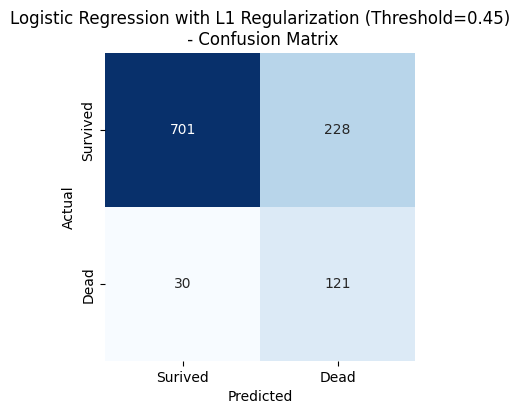

              precision    recall  f1-score   support

           0       0.96      0.75      0.84       929
           1       0.35      0.80      0.48       151

    accuracy                           0.76      1080
   macro avg       0.65      0.78      0.66      1080
weighted avg       0.87      0.76      0.79      1080



In [ ]:

util.evaluate_classification_model(y_prob_test,0.45, y_test, model_name='Logistic Regression with L1 Regularization')

## Feature Importance

In [ ]:
# Feature Importance from Logistic Regression with L1 Regularization
coef_df = pd.DataFrame({
    'feature': X_train.columns,
    'coef': logreg_l1.coef_.flatten()})
coef_df['abs_coef'] = coef_df['coef'].abs()
coef_df.sort_values('abs_coef', ascending=False, inplace=True)
print(coef_df)


            feature      coef  abs_coef
21         GCS_last -0.805075  0.805075
88         BUN_last  0.707428  0.707428
7              CSRU -0.558133  0.558133
84         ALP_last  0.545834  0.545834
59     NIMAP_median  0.543042  0.543042
..              ...       ...       ...
98       PaCO2_last  0.000000  0.000000
115  DiasABP_tested  0.000000  0.000000
112      AST_tested  0.000000  0.000000
110      ALP_tested  0.000000  0.000000
122   SysABP_tested  0.000000  0.000000

[125 rows x 3 columns]


In [ ]:
# Plot Top 25 Features
import utility as util
util.plot_top25_feature_importance(coef_df, model_name='Baseline Logistic Regression with L1 Regularization (Raw Featuyres)')

In [ ]:
# Filter features that have zero coefficients
features_zero_coef = coef_df[coef_df['coef'] == 0]['feature'].tolist()
features_zero_coef.sort()
print('Number of features with zero coefficients:', len(features_zero_coef))
print('Features with zero coefficients:', features_zero_coef)

# Filter features with very low coefficients
features_low_coef = coef_df[coef_df['abs_coef'] <0.1]['feature'].tolist()
features_low_coef.sort()
print('Number of features with low coefficients:', len(features_low_coef))
print('Features with low coefficients:', features_low_coef)

Number of features with zero coefficients: 8
Features with zero coefficients: ['ALP_tested', 'AST_tested', 'DiasABP_tested', 'NIMAP_last', 'PaCO2_last', 'SysABP_first', 'SysABP_lowest', 'SysABP_tested']
Number of features with low coefficients: 62
Features with low coefficients: ['ALP_tested', 'AST_first', 'AST_last', 'AST_tested', 'Albumin_last', 'Albumin_tested', 'Bilirubin_tested', 'Cholesterol_tested', 'Creatinine_first', 'DiasABP_last', 'DiasABP_median', 'DiasABP_tested', 'FiO2_last', 'GCS_lowest', 'GCS_median', 'Glucose_first', 'Glucose_lowest', 'HCT_first', 'HCT_last', 'HR_first', 'HR_lowest', 'HR_median', 'Height', 'Height_tested', 'K_first', 'K_last', 'Lactate_first', 'Lactate_tested', 'MAP_first', 'MAP_last', 'MAP_lowest', 'MAP_median', 'MAP_tested', 'Mg_first', 'Mg_last', 'NIDiasABP_last', 'NIDiasABP_lowest', 'NIMAP_last', 'NISysABP_highest', 'NISysABP_last', 'NISysABP_median', 'PaCO2_last', 'PaO2_first', 'PaO2_last', 'SICU', 'SaO2_first', 'SaO2_lowest', 'SaO2_tested', 'SysA

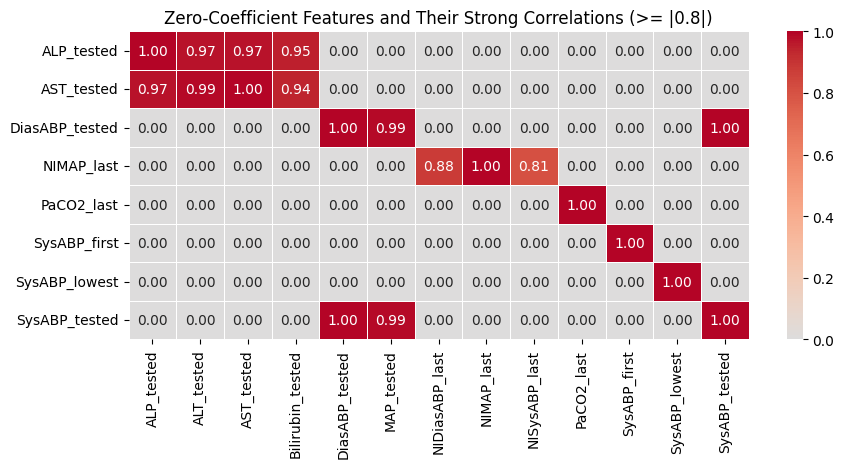

In [ ]:
# Full correlation matrix
corr_matrix=X_train[sorted(X_train.columns)].corr()

# Columns where zero-coef features have |corr| >= 0.8
mask = (
    corr_matrix.loc[features_zero_coef, :].gt(0.8).any() |
    corr_matrix.loc[features_zero_coef, :].lt(-0.8).any()
)

correlated_features = corr_matrix.loc[features_zero_coef, mask]

# Mask weak correlations for cleaner visualization
corr_display = correlated_features.mask(
    (correlated_features < 0.8) & (correlated_features > -0.8)
)

# Heatmap
plt.figure(figsize=(10,4))
sns.heatmap(corr_display.fillna(0), annot=True, cmap='coolwarm', fmt=".2f", center=0, linewidths=0.5)
plt.title('Zero-Coefficient Features and Their Strong Correlations (>= |0.8|)')
plt.show()


In [ ]:
# Find highly correlated pairs
threshold = 0.8
high_corr_pairs_idx = np.where(np.abs(corr_matrix) > threshold)

# Filter out duplicates and self-correlation
high_corr_pairs = [
    (corr_matrix.index[x], corr_matrix.columns[y], corr_matrix.iloc[x, y])
    for x, y in zip(*high_corr_pairs_idx) if x != y and x < y]

# Convert to DataFrame
high_corr_df = pd.DataFrame(high_corr_pairs, columns=["Feature_1", "Feature_2", "Correlation"])
high_corr_df = high_corr_df.sort_values(by="Correlation", ascending=False).reset_index(drop=True)

In [ ]:
# Merge high correlation pairs with logistic regression coefficients
high_corr_df = high_corr_df.merge(coef_df.rename(columns={'feature': 'Feature_1', 'coef': 'Coef_1', 'abs_coef': 'Abs_Coef_1 '}), on='Feature_1')
high_corr_df = high_corr_df.merge(coef_df.rename(columns={'feature': 'Feature_2', 'coef': 'Coef_2', 'abs_coef': 'Abs_Coef_2 '}), on='Feature_2')
high_corr_df=high_corr_df.sort_values(by='Correlation', ascending=False)
high_corr_df=high_corr_df[['Feature_1','Feature_2','Correlation', 'Coef_1',   'Coef_2' ]].sort_values(['Feature_1','Feature_2'])

In [ ]:
# Identify high-correlation pairs where at least one feature has a zero coefficient
print(high_corr_df[(high_corr_df.Coef_1==0) | (high_corr_df.Coef_2==0)])

         Feature_1         Feature_2  Correlation    Coef_1    Coef_2
8       ALP_tested        ALT_tested     0.971717  0.000000  0.108786
6       ALP_tested        AST_tested     0.974201  0.000000  0.000000
10      ALP_tested  Bilirubin_tested     0.950696  0.000000 -0.005664
4       ALT_tested        AST_tested     0.991100  0.108786  0.000000
12      AST_tested  Bilirubin_tested     0.942562  0.000000 -0.005664
3   DiasABP_tested        MAP_tested     0.991733  0.000000 -0.029523
0   DiasABP_tested     SysABP_tested     1.000000  0.000000  0.000000
2       MAP_tested     SysABP_tested     0.991733 -0.029523  0.000000
21  NIDiasABP_last        NIMAP_last     0.879569 -0.044033  0.000000
34      NIMAP_last     NISysABP_last     0.808251  0.000000 -0.035738


## Baseline Model Summary

The L1-regularized logistic regression baseline model achieved an overall test accuracy of 79% with the default threshold set at 0.5, with an F1 score of 0.49, recall of 0.75, and precision of 0.37. Given the highly imbalanced nature of the ICU mortality dataset, this baseline model performs reasonably well in identifying non-survived patients, correctly capturing 75% (113/151) of deaths in the test set.

However, this performance comes at the cost of a high false positive rate. The model incorrectly flags 21% (193/929) of survived patients as non-survivors, and it also fails to identify 25% (38/151) of non-survived patients, predicitng them as survivors. This trade-off between recall and precision is expected in imbalanced clinical prediction tasks and highlights the need for further refinement beyond the baseline.

After threshold tuning, the model showed a modest improvement in recall for non-survived patients, reaching 0.81 (122/151). However, precision decreased to 0.34, and overall accuracy dropped slightly to 76%. The model still fails to correctly predict 19% (29/151) of deaths, underscoring the challenges of balancing sensitivity and specificity in clinical outcome prediction.

The L1-regularized model was selected as the baseline because it provides embedded feature selection, allowing us to identify features that contribute little predictive value due to redundancy or multicollinearity. Examination of the top 25 features by coefficient magnitude reveals both strongly positive and strongly negative coefficients, indicating features with substantial influence on mortality risk.

Notably, several clinical variables measured at different time points exhibit opposing coefficient directions. For example, GCS_first shows a positive association with mortality, while GCS_last shows a negative association, suggesting that temporal dynamics—such as patient deterioration or improvement over time—play an important role in outcome prediction. These observations motivate further exploration of temporal feature engineering.

In addition, the L1-regularized model assigns zero coefficients to six features, indicating that they do not contribute to the model’s predictions. Correlation analysis shows that five out of these six features are highly correlated with one or more retained features, reinforcing the role of L1 regularization in reducing feature redundancy.

In the next phase, we will further evaluate features using univariate statistical testing, reassess feature redundancy, and explore temporal feature engineering (e.g., first–last differences and ranges) to better capture clinically meaningful patterns and improve model performance.



# Feature Evaluation and Engineering

## ICU Lab Tests Categorized by Clinical Purpose

| **Clinical Purpose Category** | **Tests** |
|-------------------------------|-----------|
| **Liver Function** | ALP, ALT, AST, Bilirubin |
| **Kidney Function** | BUN, Creatinine |
| **Electrolytes** | Na, K, Mg |
| **Acid–Base / Metabolic** | HCO3, Lactate, pH |
| **Blood Gas / Respiratory** | PaCO2, PaO2, FiO2 |
| **Hematology** | HCT, Platelets, WBC |
| **Cardiac Markers** | TroponinI, TroponinT |
| **General Metabolic / Nutritional Status** | Albumin, Cholesterol |
| **Glucose Regulation** | Glucose |
| **Oxygenation / Perfusion** | SaO2 |
| **Vital Signs (Physiologic Measurements)** | HR, RespRate, Temp, SysABP, DiasABP, MAP, NISysABP, NIDiasABP, NIMAP |
| **Neurological Assessment** | GCS |
| **Ventilation / Respiratory Support** | MechVentStartTime, MechVentDuration, MechVentLast8Hour |
| **Renal Output** | UrineOutputSum |


## Feature Evaluation with Univariate Statistical Test

In [ ]:
high_corr_df_zero_coef=high_corr_df[(high_corr_df.Coef_1==0) | (high_corr_df.Coef_2==0)]
print(high_corr_df_zero_coef)

         Feature_1         Feature_2  Correlation    Coef_1    Coef_2
8       ALP_tested        ALT_tested     0.971717  0.000000  0.108786
6       ALP_tested        AST_tested     0.974201  0.000000  0.000000
10      ALP_tested  Bilirubin_tested     0.950696  0.000000 -0.005664
4       ALT_tested        AST_tested     0.991100  0.108786  0.000000
12      AST_tested  Bilirubin_tested     0.942562  0.000000 -0.005664
3   DiasABP_tested        MAP_tested     0.991733  0.000000 -0.029523
0   DiasABP_tested     SysABP_tested     1.000000  0.000000  0.000000
2       MAP_tested     SysABP_tested     0.991733 -0.029523  0.000000
21  NIDiasABP_last        NIMAP_last     0.879569 -0.044033  0.000000
34      NIMAP_last     NISysABP_last     0.808251  0.000000 -0.035738


In [ ]:
# Merge with high correlation pairs with zero coefficients with Fisher's Exact Test results
high_corr_df_zero_coef_univarate=high_corr_df_zero_coef.merge(fisher_exact_test_df.reset_index().rename(columns={'Feature':'Feature_1', 'Odds Ratio':'Odds_Ratio_1', 'p-value':'p-value_1', 'Odds Ratio Interpretation':'interpret_odds_ratio_1'}), on='Feature_1', how='left')
high_corr_df_zero_coef_univarate=high_corr_df_zero_coef_univarate.merge(fisher_exact_test_df.reset_index().rename(columns={'Feature':'Feature_2', 'Odds Ratio':'Odds_Ratio_2', 'p-value':'p-value_2', 'Odds Ratio Interpretation':'interpret_odds_ratio_2'}), on='Feature_2', how='left')
high_corr_df_zero_coef_univarate

Feature_1         Feature_2  Correlation    Coef_1    Coef_2  \
0      ALP_tested        ALT_tested     0.971717  0.000000  0.108786   
1      ALP_tested        AST_tested     0.974201  0.000000  0.000000   
2      ALP_tested  Bilirubin_tested     0.950696  0.000000 -0.005664   
3      ALT_tested        AST_tested     0.991100  0.108786  0.000000   
4      AST_tested  Bilirubin_tested     0.942562  0.000000 -0.005664   
5  DiasABP_tested        MAP_tested     0.991733  0.000000 -0.029523   
6  DiasABP_tested     SysABP_tested     1.000000  0.000000  0.000000   
7      MAP_tested     SysABP_tested     0.991733 -0.029523  0.000000   
8  NIDiasABP_last        NIMAP_last     0.879569 -0.044033  0.000000   
9      NIMAP_last     NISysABP_last     0.808251  0.000000 -0.035738   

   Odds_Ratio_1     p-value_1  Odds_Ratio_2     p-value_2  
0      2.125118  7.994666e-11      2.224087  7.460524e-12  
1      2.125118  7.994666e-11      2.211331  8.081909e-12  
2      2.125118  7.994666e-11      2.176996  2.614702e-11  
3      2.224087  7.460524e-12      2.211331  8.081909e-12  
4      2.211331  8.081909e-12      2.176996  2.614702e-11  
5      1.271571  6.371463e-02      1.300505  4.120693e-02  
6      1.271571  6.371463e-02      1.271571  6.371463e-02  
7      1.300505  4.120693e-02      1.271571  6.371463e-02  
8           NaN           NaN           NaN           NaN  
9           NaN           NaN           NaN           NaN

In [ ]:
#Merge with Mann-Whitney U Test results
high_corr_df_zero_coef_univarate=high_corr_df_zero_coef_univarate.merge(mann_whitney_u_test_df.reset_index().rename(columns={'Feature':'Feature_1', 'U-statistic':'U_statistic_1', 'p-value':'mw_p_value_1', 'Median Survived':'Median_Survived_1', 'Median Non-Survived':'Median_Non_Survived_1', 'Effect Size':'Effect_Size_1', 'Effect Size Abs':'Effect_Size_Abs_1', 'Effect Size Interpretation':'Effect_Size_Interpretation_1'}), on='Feature_1', how='left')  
high_corr_df_zero_coef_univarate=high_corr_df_zero_coef_univarate.merge(mann_whitney_u_test_df.reset_index().rename(columns={'Feature':'Feature_2', 'U-statistic':'U_statistic_2', 'p-value':'mw_p_value_2', 'Median Survived':'Median_Survived_2', 'Median Non-Survived':'Median_Non_Survived_2', 'Effect Size':'Effect_Size_2', 'Effect Size Abs':'Effect_Size_Abs_2', 'Effect Size Interpretation':'Effect_Size_Interpretation_2'}), on='Feature_2', how='left')
high_corr_df_zero_coef_univarate     

Feature_1         Feature_2  Correlation    Coef_1    Coef_2  \
0      ALP_tested        ALT_tested     0.971717  0.000000  0.108786   
1      ALP_tested        AST_tested     0.974201  0.000000  0.000000   
2      ALP_tested  Bilirubin_tested     0.950696  0.000000 -0.005664   
3      ALT_tested        AST_tested     0.991100  0.108786  0.000000   
4      AST_tested  Bilirubin_tested     0.942562  0.000000 -0.005664   
5  DiasABP_tested        MAP_tested     0.991733  0.000000 -0.029523   
6  DiasABP_tested     SysABP_tested     1.000000  0.000000  0.000000   
7      MAP_tested     SysABP_tested     0.991733 -0.029523  0.000000   
8  NIDiasABP_last        NIMAP_last     0.879569 -0.044033  0.000000   
9      NIMAP_last     NISysABP_last     0.808251  0.000000 -0.035738   

   Odds_Ratio_1     p-value_1  Odds_Ratio_2     p-value_2  U_statistic_1  ...  \
0      2.125118  7.994666e-11      2.224087  7.460524e-12            NaN  ...   
1      2.125118  7.994666e-11      2.211331  8.081909e-12            NaN  ...   
2      2.125118  7.994666e-11      2.176996  2.614702e-11            NaN  ...   
3      2.224087  7.460524e-12      2.211331  8.081909e-12            NaN  ...   
4      2.211331  8.081909e-12      2.176996  2.614702e-11            NaN  ...   
5      1.271571  6.371463e-02      1.300505  4.120693e-02            NaN  ...   
6      1.271571  6.371463e-02      1.271571  6.371463e-02            NaN  ...   
7      1.300505  4.120693e-02      1.271571  6.371463e-02            NaN  ...   
8           NaN           NaN           NaN           NaN       439681.5  ...   
9           NaN           NaN           NaN           NaN       437763.0  ...   

   Effect_Size_1  Effect_Size_Abs_1  Effect_Size_Interpretation_1  \
0            NaN                NaN                           NaN   
1            NaN                NaN                           NaN   
2            NaN                NaN                           NaN   
3            NaN                NaN                           NaN   
4            NaN                NaN                           NaN   
5            NaN                NaN                           NaN   
6            NaN                NaN                           NaN   
7            NaN                NaN                           NaN   
8      -0.152302           0.152302                         Small   
9      -0.147274           0.147274                         Small   

   U_statistic_2  mw_p_value_2 Median_Survived_2  Median_Non_Survived_2  \
0            NaN           NaN               NaN                    NaN   
1            NaN           NaN               NaN                    NaN   
2            NaN           NaN               NaN                    NaN   
3            NaN           NaN               NaN                    NaN   
4            NaN           NaN               NaN                    NaN   
5            NaN           NaN               NaN                    NaN   
6            NaN           NaN               NaN                    NaN   
7            NaN           NaN               NaN                    NaN   
8       437763.0      0.000009              76.0                 74.165   
9       422033.5      0.001370             118.0                116.000   

   Effect_Size_2  Effect_Size_Abs_2  Effect_Size_Interpretation_2  
0            NaN                NaN                           NaN  
1            NaN                NaN                           NaN  
2            NaN                NaN                           NaN  
3            NaN                NaN                           NaN  
4            NaN                NaN                           NaN  
5            NaN                NaN                           NaN  
6            NaN                NaN                           NaN  
7            NaN                NaN                           NaN  
8      -0.147274           0.147274                         Small  
9      -0.106051           0.106051                      

In [ ]:
# Remove DiasABP_tested and SysABP_tested pairs due to high correlation low discrimative power
X_train=X_train.drop(columns=['DiasABP_tested','SysABP_tested'], axis=1)
X_test=X_test.drop(columns=['DiasABP_tested','SysABP_tested'], axis=1)

### Feature Reduction Based on Correlation and Univariate Tests

After reviewing the highly correlated feature pairs and examining the coefficients from the L1-regularized baseline model, we further cross-checked with the univariate statistical tests.  

Features such as **DiasABP_tested** and **SysABP_tested** were found to be:

- **Highly correlated** to each other (correlation = 1).  
- **Non-significant** in the univariate analysis, with p-value = 0.06.  
- **Weakly associated** with the outcome, having a low positive odds ratio of 1.27.  
- **Highly correlated** with **MAP_tested**, which has a significant p-value (< 0.05) and stronger discriminative power.  

Given their weak predictive signal and redundancy, **DiasABP_tested** and **SysABP_tested** are **removed** from the feature set to reduce potential noise and improve model interpretability.


## Feature Engineering

In [ ]:
# Additional Clinical Features for BMI and BUN/Creatinine Ratio
def clinical_feature(df,new_column, column1, column2):
    if column2=='Height':
        df[new_column + '_first'] = df[column1 + '_first'] / df[column2]
        df[new_column + '_last'] = df[column1 + '_last'] / df[column2]
    else:
        df[new_column + '_first'] = df[column1 + '_first'] / df[column2 + '_first']
        df[new_column + '_last'] = df[column1 + '_last'] / df[column2 + '_last']
    return df
X_train = clinical_feature(X_train, 'BUN_Creatinine_Ratio', 'BUN', 'Creatinine')
X_test = clinical_feature(X_test, 'BUN_Creatinine_Ratio', 'BUN', 'Creatinine')
X_train = clinical_feature(X_train, 'BMI', 'Weight', 'Height')
X_test = clinical_feature(X_test, 'BMI', 'Weight', 'Height')

In [ ]:
# Temporal Feature Engineering
def feature_engineer_temporal(df,column_name, high_low=False):
    df[column_name+'_delta'] = df[column_name+'_last'] - df[column_name+'_first']
    df[column_name+'_ratio'] = df[column_name+'_last'] / df[column_name+'_first']
    if high_low:
        df[column_name+'_range'] = df[column_name+'_highest'] - df[column_name+'_lowest']
    return df

In [ ]:
for name in ['ALP', 'ALT', 'AST', 'Albumin', 'BUN','Bilirubin', 'Creatinine','DiasABP', 'FiO2','GCS','Glucose', 'HCO3','HCT','HR','K','Lactate', 'MAP', 'Mg','NIDiasABP','NIMAP','NISysABP','Na','PaCO2','Platelets','SaO2', 'SysABP','Temp', 'Weight', 'pH','BMI','BUN_Creatinine_Ratio']:
    high_low = True if name in ['DiasABP', 'GCS', 'Glucose','HR', 'MAP','NIDiasABP','NIMAP','NISysABP','SaO2', 'SysABP','Temp'] else False
    X_train = feature_engineer_temporal(X_train, name, high_low)
    X_test = feature_engineer_temporal(X_test, name, high_low)

In [ ]:
# Get the temporal feature columns
new_features = [col for col in X_train.columns if col.endswith('_delta') or col.endswith('_ratio') or col.endswith('_range')]+['BMI_first','BMI_last','BUN_Creatinine_Ratio_first','BUN_Creatinine_Ratio_last']

In [ ]:
train_df_FeatureEngineer=pd.concat([X_train, y_train], axis=1)

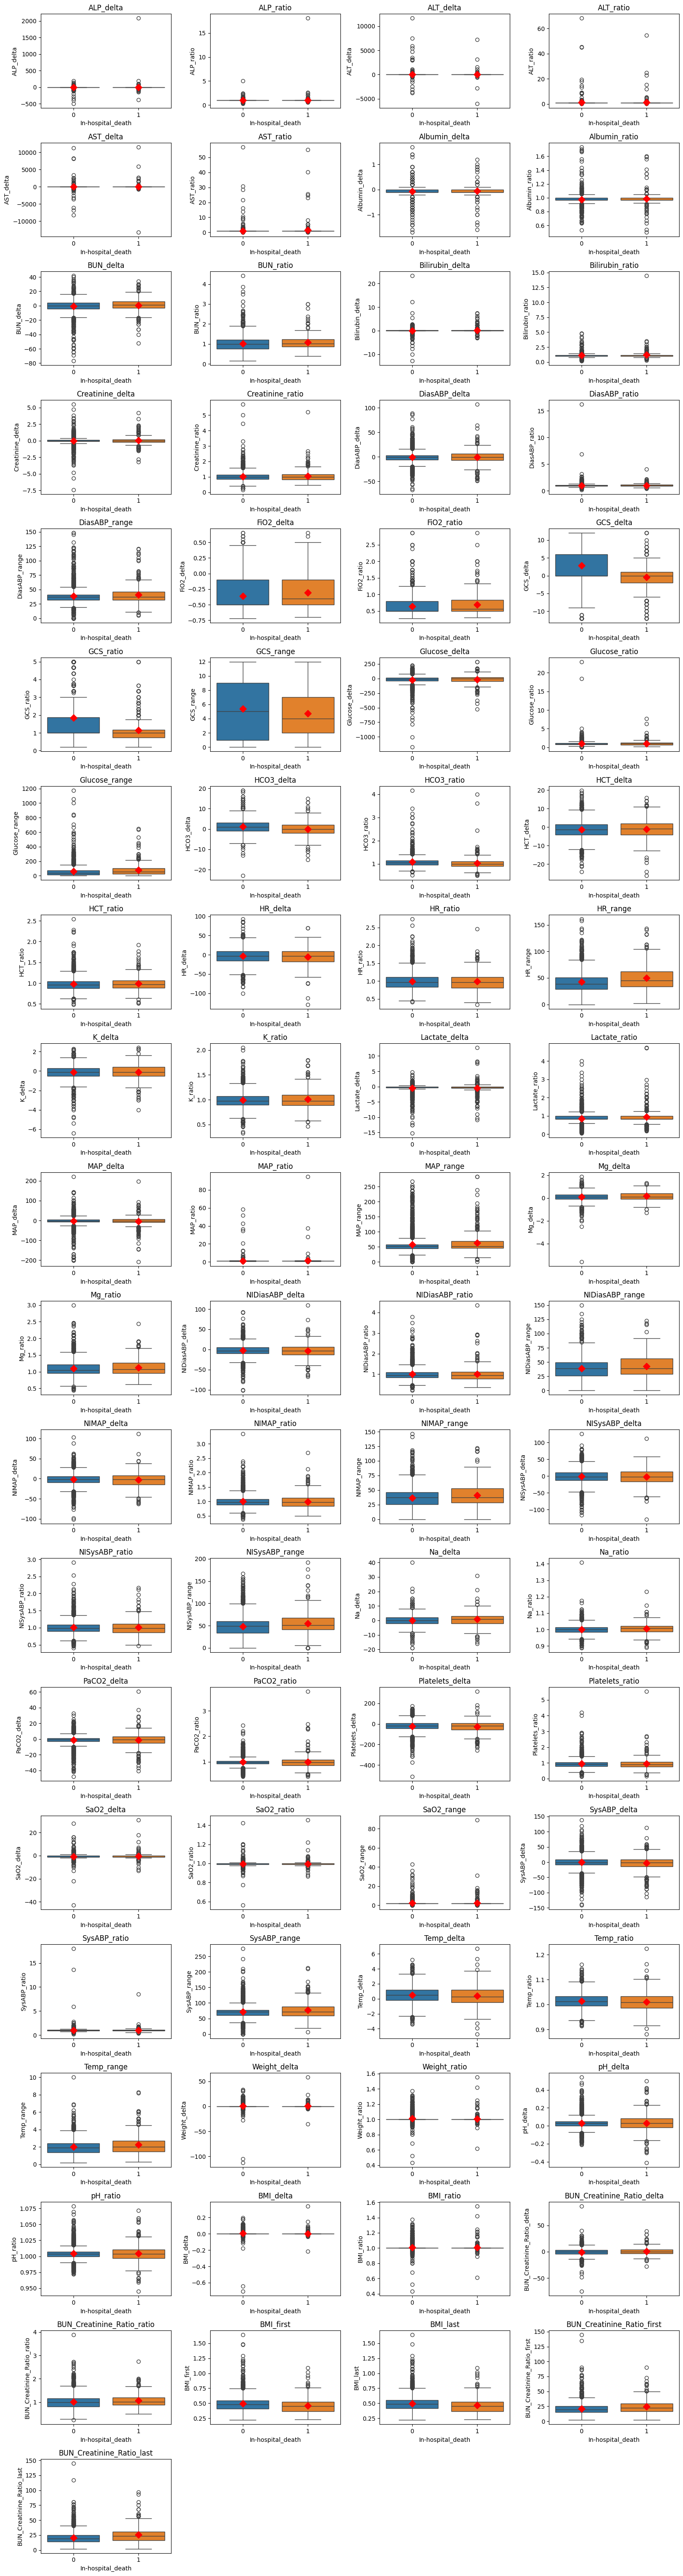

In [ ]:
# boxplots for temporal features
util.plot_boxplots(train_df_FeatureEngineer, new_features, 'In-hospital_death')

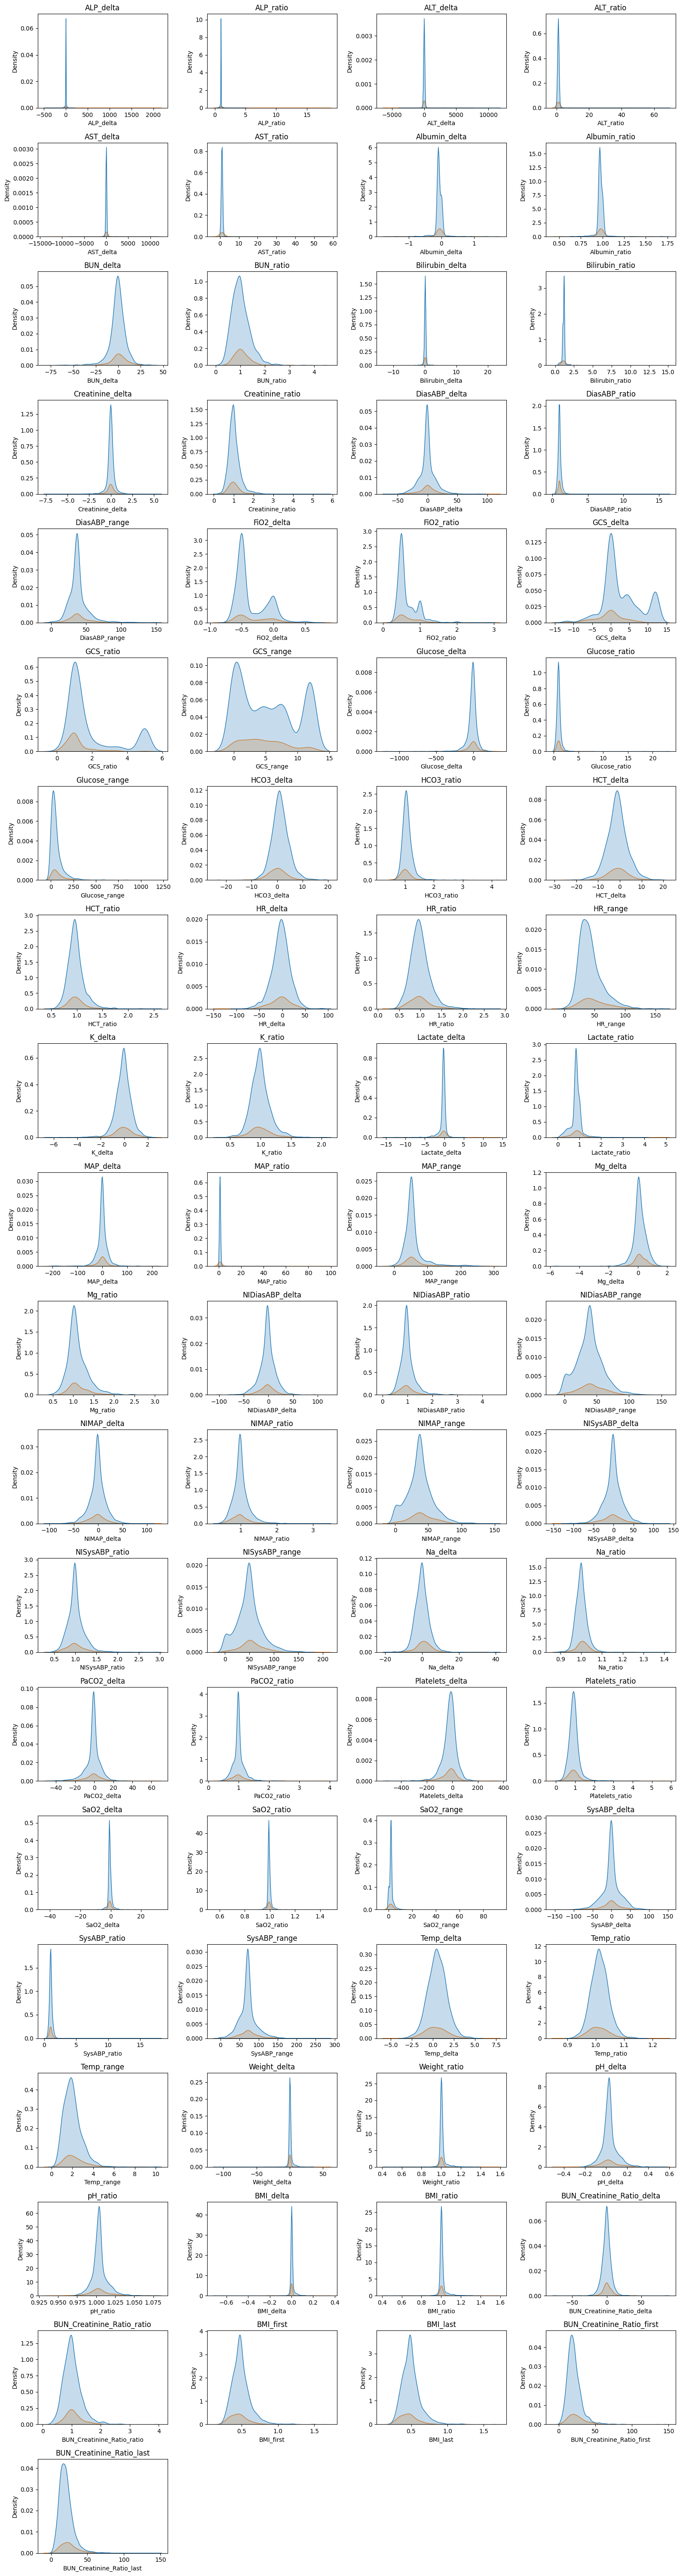

In [ ]:
# KDE plots for temporal features
util.plot_kde_plots(train_df_FeatureEngineer, new_features, 'In-hospital_death')

In [ ]:
#Call the mann_whitney_u_test function
mw_newFeature_df=util.mann_whitney_u_test(train_df_FeatureEngineer, outcome_col='In-hospital_death', numeric_cols=new_features)

# Sort by p-value and filter significant features
mw_newFeature_df=mw_newFeature_df.sort_values(by='p-value', ascending=True)
    
mw_newFeature_df['Effect Size Interpretation'] = mw_newFeature_df['Effect Size Abs'].apply(util.interpret_effect_size)
mw_newFeature_df

U-statistic       p-value  Median Survived  \
Feature                                                                 
GCS_delta                     510490.0  1.425046e-25         0.000000   
GCS_ratio                     504212.5  2.790973e-23         1.000000   
BUN_Creatinine_Ratio_last     291364.0  1.041387e-12        18.888889   
Glucose_range                 302904.5  5.180258e-10        39.000000   
HCO3_delta                    456205.0  3.137313e-09         1.000000   
...                                ...           ...              ...   
Creatinine_delta              377794.5  7.642500e-01         0.000000   
Creatinine_ratio              378124.0  7.844887e-01         1.000000   
MAP_delta                     383474.5  8.782251e-01        -1.000000   
MAP_ratio                     382440.0  9.442516e-01         0.987805   
PaCO2_delta                   382273.0  9.551005e-01        -1.000000   

                           Median Non-Survived  Effect Size  Effect Size Abs  \
Feature                                                                        
GCS_delta                             0.000000    -0.337874         0.337874   
GCS_ratio                             1.000000    -0.321422         0.321422   
BUN_Creatinine_Ratio_last            23.390805     0.236403         0.236403   
Glucose_range                        53.000000     0.206159         0.206159   
HCO3_delta                            0.000000    -0.195606         0.195606   
...                                        ...          ...              ...   
Creatinine_delta                      0.000000     0.009889         0.009889   
Creatinine_ratio                      1.000000     0.009026         0.009026   
MAP_delta                            -1.000000    -0.004996         0.004996   
MAP_ratio                             0.987805    -0.002285         0.002285   
PaCO2_delta                          -1.000000    -0.001848         0.001848   

                          Effect Size Interpretation  
Feature                                               
GCS_delta                                     Medium  
GCS_ratio                                     Medium  
BUN_Creatinine_Ratio_last                      Small  
Glucose_range                                  Small  
HCO3_delta                                     Small  
...                                              ...  
Creatinine_delta                          Negligible  
Creatinine_ratio                          Negligible  
MAP_delta                                 Negligible  
MAP_ratio                                 Negligible  
PaCO2_delta                               Negligible  

[77 rows x 7 columns]

In [ ]:
mw_newFeature_df_nonSignificant= mw_newFeature_df[mw_newFeature_df['p-value'] >= 0.05]
mw_newFeature_df_nonSignificant


U-statistic   p-value  Median Survived  Median Non-Survived  \
Feature                                                                         
GCS_range            403453.0  0.081105         5.000000             4.000000   
Glucose_ratio        361415.0  0.111425         0.921819             0.966283   
Glucose_delta        362144.5  0.124970       -10.000000            -5.000000   
ALT_ratio            368650.5  0.127197         1.000000             1.000000   
ALT_delta            369384.5  0.150268         0.000000             0.000000   
NIMAP_ratio          399504.0  0.156138         0.974359             0.974359   
NIDiasABP_ratio      399128.5  0.164960         0.949153             0.949153   
NIMAP_delta          398582.5  0.178382        -2.000000            -2.000000   
NIDiasABP_delta      397151.0  0.217497        -3.000000            -3.000000   
HCT_ratio            367076.0  0.252411         0.958553             0.971025   
ALP_delta            369208.5  0.272974        -0.500000            -0.500000   
ALP_ratio            369216.0  0.273265         0.993506             0.993506   
SaO2_delta           370472.0  0.308216        -1.000000            -1.000000   
HCT_delta            368785.0  0.312709        -1.400000            -0.900000   
NISysABP_ratio       394112.0  0.321286         0.983333             0.983333   
pH_ratio             392984.5  0.363209         1.004065             1.004065   
DiasABP_ratio        370348.5  0.367813         0.983607             0.983607   
NISysABP_delta       392735.5  0.377041        -2.000000            -2.000000   
pH_delta             392252.0  0.393737         0.030000             0.030000   
DiasABP_delta        371016.5  0.395948        -1.000000            -1.000000   
Platelets_delta      391879.5  0.415426       -17.000000           -17.000000   
HR_delta             390436.0  0.483650        -3.000000            -3.000000   
Platelets_ratio      390418.0  0.484598         0.907935             0.899153   
SysABP_delta         389879.0  0.504073        -1.000000            -1.000000   
SysABP_ratio         389253.5  0.537407         0.991803             0.991803   
SaO2_ratio           375409.5  0.582778         0.989796             0.989796   
HR_ratio             388202.0  0.600345         0.965909             0.968586   
SaO2_range           386818.0  0.632921         2.000000             2.000000   
PaCO2_ratio          387493.0  0.637055         0.975000             0.975000   
K_ratio              376478.5  0.687598         0.977273             0.977273   
K_delta              376654.0  0.697757        -0.100000            -0.100000   
Creatinine_delta     377794.5  0.764250         0.000000             0.000000   
Creatinine_ratio     378124.0  0.784489         1.000000             1.000000   
MAP_delta            383474.5  0.878225        -1.000000            -1.000000   
MAP_ratio            382440.0  0.944252         0.987805             0.987805   
PaCO2_delta          382273.0  0.955100        -1.000000            -1.000000   

                  Effect Size  Effect Size Abs Effect Size Interpretation  
Feature                                                                    
GCS_range           -0.057355         0.057355                 Negligible  
Glucose_ratio        0.052816         0.052816                 Negligible  
Glucose_delta        0.050904         0.050904                 Negligible  
ALT_ratio            0.033854         0.033854                 Negligible  
ALT_delta            0.031930         0.031930                 Negligible  
NIMAP_ratio         -0.047006         0.047006                 Negligible  
NIDiasABP_ratio     -0.046022         0.046022                 Negligible  
NIMAP_delta         -0.044591         0.044591                 Negligible  
NIDiasABP_delta     -0.040839         0.040839                 Negligible  
HCT_ratio            0.037980         0.037980                 Negligible  
ALP_delta            0.0323

In [ ]:
mw_newFeature_df_significant = mw_newFeature_df[mw_newFeature_df['p-value'] < 0.05]
mw_newFeature_df_significant

U-statistic       p-value  Median Survived  \
Feature                                                                  
GCS_delta                      510490.0  1.425046e-25         0.000000   
GCS_ratio                      504212.5  2.790973e-23         1.000000   
BUN_Creatinine_Ratio_last      291364.0  1.041387e-12        18.888889   
Glucose_range                  302904.5  5.180258e-10        39.000000   
HCO3_delta                     456205.0  3.137313e-09         1.000000   
BUN_Creatinine_Ratio_first     312404.0  4.681960e-08        19.230769   
HCO3_ratio                     450125.5  5.939190e-08         1.043478   
HR_range                       313695.0  8.253613e-08        39.000000   
BMI_last                       445827.0  3.846277e-07         0.484136   
Na_delta                       320919.0  1.498934e-06         0.000000   
NISysABP_range                 321020.0  1.671088e-06        49.000000   
BMI_first                      441452.5  2.236887e-06         0.476792   
Na_ratio                       322213.5  2.642747e-06         1.000000   
Albumin_delta                  331730.5  5.442107e-06        -0.100000   
AST_ratio                      333704.0  2.416950e-05         0.943820   
Albumin_ratio                  335903.0  3.456221e-05         0.966667   
AST_delta                      338072.5  1.245254e-04        -2.500000   
Temp_range                     333685.0  1.547586e-04         1.900000   
NIMAP_range                    337703.0  5.221546e-04        37.000000   
BUN_Creatinine_Ratio_ratio     339397.5  8.661183e-04         0.987654   
Lactate_ratio                  342141.5  1.016779e-03         0.842105   
FiO2_delta                     342208.5  1.057915e-03        -0.500000   
BUN_ratio                      340283.5  1.107384e-03         1.000000   
SysABP_range                   341238.0  1.209556e-03        71.500000   
BUN_Creatinine_Ratio_delta     341140.0  1.407426e-03        -0.213796   
BUN_delta                      341302.0  1.452615e-03         0.000000   
FiO2_ratio                     343679.5  1.597262e-03         0.500000   
MAP_range                      342734.5  1.793129e-03        52.000000   
NIDiasABP_range                342287.5  1.887041e-03        39.000000   
Weight_delta                   412062.5  3.172743e-03         0.000000   
BMI_delta                      412039.0  3.196729e-03         0.000000   
Weight_ratio                   411978.0  3.257746e-03         1.000000   
BMI_ratio                      411957.0  3.279742e-03         1.000000   
Lactate_delta                  350667.5  9.964695e-03        -0.300000   
Mg_delta                       349700.0  1.160653e-02         0.100000   
Mg_ratio                       352295.5  2.054165e-02         1.052632   
DiasABP_range                  352940.0  2.118540e-02        37.000000   
Bilirubin_ratio                406920.5  2.452001e-02         1.166667   
Temp_delta                     409308.0  2.843355e-02         0.500000   
Temp_ratio                     409208.5  2.903609e-02         1.013175   
Bilirubin_delta                405226.0  3.502660e-02         0.100000   

                            Median Non-Survived  Effect Size  Effect Size Abs  \
Feature                                                                         
GCS_delta                              0.000000    -0.337874         0.337874   
GCS_ratio                              1.000000    -0.321422         0.321422   
BUN_Creatinine_Ratio_last             23.390805     0.236403         0.236403   
Glucose_range                         53.000000     0.206159         0.206159   
HCO3_delta                             0.000000    -0.195606         0.195606   
BUN_Creatinine_Ratio_first            22.500000     0.181263         0.181263   
HCO3_ratio                             1.000000    -0.179673         0.179673   
HR_range                              45.000000     0.177879         0.177879   
BMI_last                           

In [ ]:
# Remove temporal features with no significant difference
drop_new_features = mw_newFeature_df_nonSignificant.index.tolist()
print('Drop temporal features with no significant difference:', drop_new_features)
X_train=X_train.drop(columns=drop_new_features, axis=1)
X_test=X_test.drop(columns=drop_new_features, axis=1)

Drop temporal features with no significant difference: ['GCS_range', 'Glucose_ratio', 'Glucose_delta', 'ALT_ratio', 'ALT_delta', 'NIMAP_ratio', 'NIDiasABP_ratio', 'NIMAP_delta', 'NIDiasABP_delta', 'HCT_ratio', 'ALP_delta', 'ALP_ratio', 'SaO2_delta', 'HCT_delta', 'NISysABP_ratio', 'pH_ratio', 'DiasABP_ratio', 'NISysABP_delta', 'pH_delta', 'DiasABP_delta', 'Platelets_delta', 'HR_delta', 'Platelets_ratio', 'SysABP_delta', 'SysABP_ratio', 'SaO2_ratio', 'HR_ratio', 'SaO2_range', 'PaCO2_ratio', 'K_ratio', 'K_delta', 'Creatinine_delta', 'Creatinine_ratio', 'MAP_delta', 'MAP_ratio', 'PaCO2_delta']


In [ ]:
# Remove static features that is patient specific
patient_specific_features=['Weight','Weight_first','Weight_last','Height']
X_train=X_train.drop(columns=patient_specific_features, axis=1)
X_test=X_test.drop(columns=patient_specific_features, axis=1)

In [ ]:
# Add Number of Kidney Panels Tests Feature
X_train['Number_Kidney_Panels_Tested'] = X_train[['ALT_tested', 'ALP_tested','AST_tested','Bilirubin_tested']].sum(axis=1).astype(int)
print('Train Data:', X_train['Number_Kidney_Panels_Tested'].value_counts())

X_test['Number_Kidney_Panels_Tested'] = X_test[['ALT_tested', 'ALP_tested','AST_tested','Bilirubin_tested']].sum(axis=1).astype(int)
print('Test Data:', X_test['Number_Kidney_Panels_Tested'].value_counts())

Train Data: Number_Kidney_Panels_Tested
0    1395
4    1036
1      36
3      34
2      19
Name: count, dtype: int64
Test Data: Number_Kidney_Panels_Tested
0    592
4    456
3     14
1     10
2      8
Name: count, dtype: int64


## Feature Evaluation and Engineering Summary

### 1. Highly Correlated and Redundant Features
After reviewing highly correlated feature pairs, examining L1-regularized baseline model coefficients, and cross-checking with univariate statistical tests:

- **DiasABP_tested** and **SysABP_tested** were found to be:  
  - **Perfectly correlated** (correlation = 1)  
  - **Non-significant** in univariate analysis (p-value = 0.06)  
  - **Weakly associated** with the outcome (odds ratio = 1.27)  
  - **Highly correlated** with **MAP_tested**, which shows significant predictive power (p-value < 0.05)  

Given their weak signal and redundancy, **DiasABP_tested** and **SysABP_tested** were **removed** from the feature set to reduce noise and improve model interpretability.

### 2. Temporal Feature Engineering
Features capturing ICU measurements over time (first, last, highest, lowest) were engineered to capture:

- **Change (delta):** last − first measurement  
- **Ratio:** last ÷ first measurement  
- **Range:** highest − lowest measurement  

Mann–Whitney U tests were performed to evaluate distribution differences between survived and non-survived patients and assess their discriminative power. Features that are **non-significant (p-value > 0.05) with negligible effect size** were excluded, as these additional features could introduce noise and reduce model interpretability.

### 3. Aggregated Liver Panel Feature
As liver panel tests (ALP, ALT, AST, Bilirubin) were highly correlated, a new feature was created to summarize the **total number of liver tests performed** during the ICU stay.  



# Logistic Model with New Features

In [ ]:
# Features scaling
scaler = StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)


# Add the feature names back to scaled data
X_train_scaled_df=pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df=pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [ ]:
# Logistic Model with L1 Regularization
logreg_l1_m2 = LogisticRegression(penalty='l1', solver='liblinear', random_state=42, class_weight='balanced',max_iter=1000)
logreg_l1_m2.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, penalty='l1',
                   random_state=42, solver='liblinear')

In [ ]:
print('Number of iterations:', logreg_l1_m2.n_iter_[0])

Number of iterations: 28


In [ ]:
# Predictions Probability
y_prob_test2=logreg_l1_m2.predict_proba(X_test_scaled)[:,1]

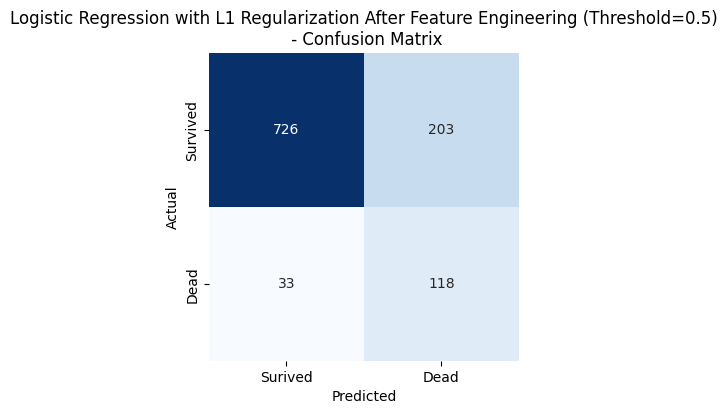

              precision    recall  f1-score   support

           0       0.96      0.78      0.86       929
           1       0.37      0.78      0.50       151

    accuracy                           0.78      1080
   macro avg       0.66      0.78      0.68      1080
weighted avg       0.87      0.78      0.81      1080



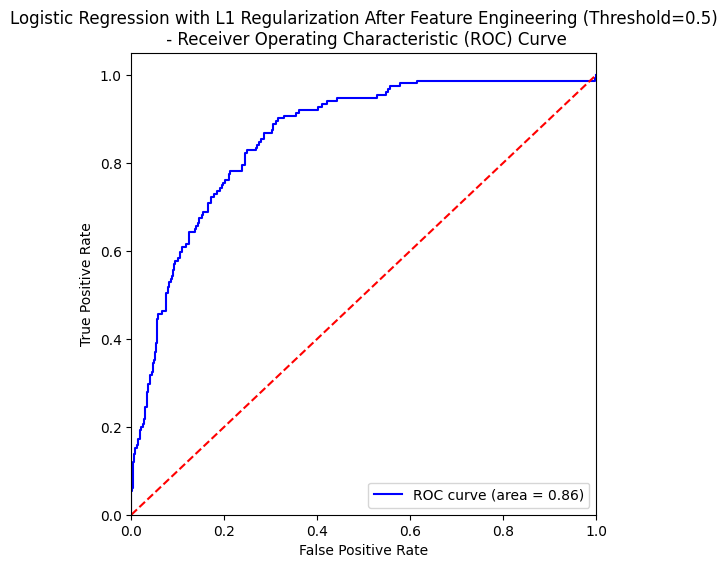

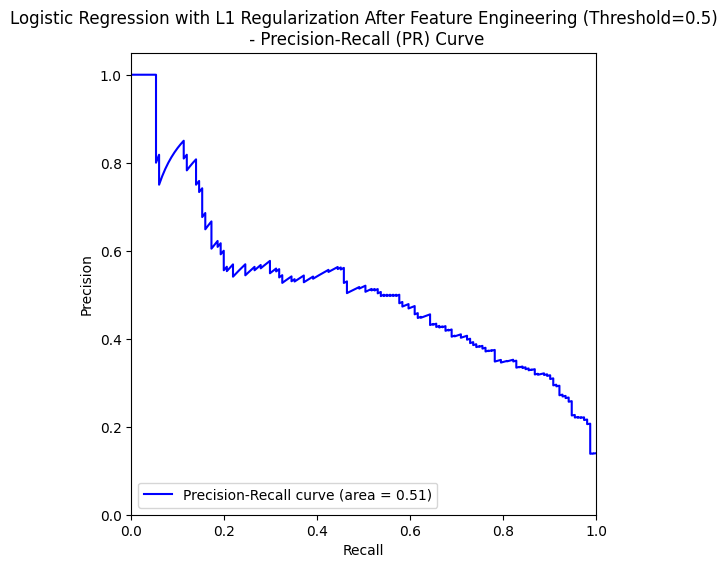

In [ ]:
util.evaluate_classification_model(y_prob_test2, 0.5, y_test, model_name='Logistic Regression with L1 Regularization After Feature Engineering')

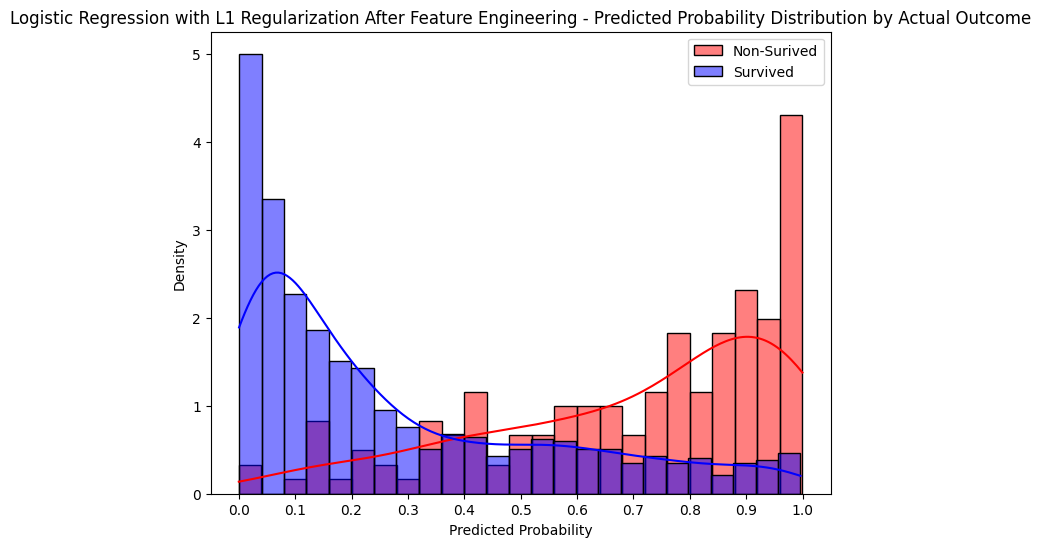

In [ ]:
# Visualize Threshold Distribution
util.plot_threshold_distribution(y_prob_test2, y_test, model_name='Logistic Regression with L1 Regularization After Feature Engineering')

In [ ]:
#Threshold Analysis
util.threshold_analysis(y_prob_test2, y_test, threshold_range=np.arange(0.3, 0.725, 0.01))

Threshold 0.300 -> Recall: 0.901, FPR: 0.326, Precisinon: 0.310
Threshold 0.310 -> Recall: 0.901, FPR: 0.322, Precisinon: 0.313
Threshold 0.320 -> Recall: 0.901, FPR: 0.318, Precisinon: 0.316
Threshold 0.330 -> Recall: 0.894, FPR: 0.313, Precisinon: 0.317
Threshold 0.340 -> Recall: 0.887, FPR: 0.306, Precisinon: 0.321
Threshold 0.350 -> Recall: 0.874, FPR: 0.305, Precisinon: 0.318
Threshold 0.360 -> Recall: 0.868, FPR: 0.296, Precisinon: 0.323
Threshold 0.370 -> Recall: 0.868, FPR: 0.286, Precisinon: 0.330
Threshold 0.380 -> Recall: 0.854, FPR: 0.282, Precisinon: 0.330
Threshold 0.390 -> Recall: 0.848, FPR: 0.277, Precisinon: 0.332
Threshold 0.400 -> Recall: 0.841, FPR: 0.270, Precisinon: 0.336
Threshold 0.410 -> Recall: 0.828, FPR: 0.264, Precisinon: 0.338
Threshold 0.420 -> Recall: 0.828, FPR: 0.255, Precisinon: 0.345
Threshold 0.430 -> Recall: 0.821, FPR: 0.249, Precisinon: 0.349
Threshold 0.440 -> Recall: 0.795, FPR: 0.243, Precisinon: 0.347
Threshold 0.450 -> Recall: 0.795, FPR: 0

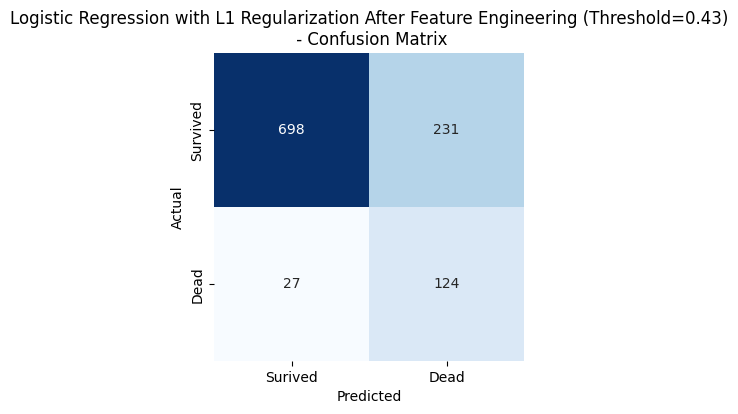

              precision    recall  f1-score   support

           0       0.96      0.75      0.84       929
           1       0.35      0.82      0.49       151

    accuracy                           0.76      1080
   macro avg       0.66      0.79      0.67      1080
weighted avg       0.88      0.76      0.79      1080



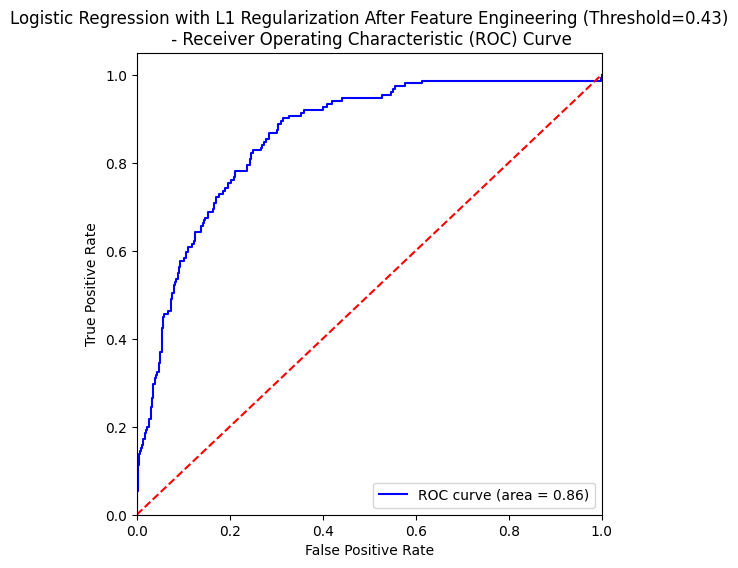

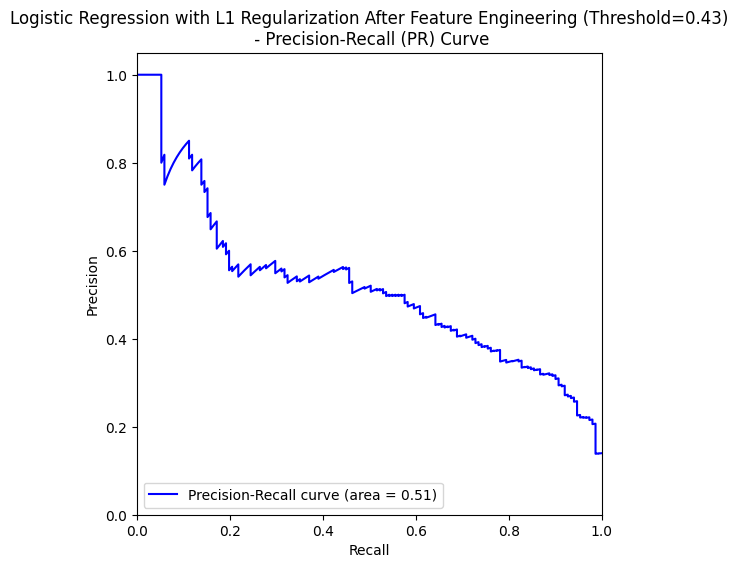

In [ ]:
util.evaluate_classification_model(y_prob_test2, 0.43, y_test, model_name='Logistic Regression with L1 Regularization After Feature Engineering')

## Feature Importance After Feature Engineering

In [ ]:
# Feature Importance from Logistic Regression with L1 Regularization
coef_df_m2 = pd.DataFrame({
    'feature': X_train.columns,
    'coef': logreg_l1_m2.coef_.flatten()})
coef_df_m2['abs_coef'] = coef_df_m2['coef'].abs()
coef_df_m2.sort_values('abs_coef', ascending=False, inplace=True)

In [ ]:
coef_df_m2.head(25)

feature      coef  abs_coef
156           BMI_delta  1.330057  1.330057
154        Weight_delta -1.014789  1.014789
19             GCS_last -0.559058  0.559058
5                  CSRU -0.550732  0.550732
81             ALP_last  0.532409  0.532409
57         NIMAP_median  0.457699  0.457699
117  UrineOutput_tested -0.455054  0.455054
41          GCS_highest -0.449762  0.449762
2                   Age  0.438949  0.438949
62            ALP_first -0.396214  0.396214
20         Glucose_last  0.379384  0.379384
105     RespRate_tested -0.375804  0.375804
134           GCS_delta -0.371027  0.371027
137          HCO3_delta -0.366736  0.366736
56     NIDiasABP_median -0.366154  0.366154
100    MechVentDuration  0.363899  0.363899
82             ALT_last -0.363399  0.363399
127           BUN_delta  0.348379  0.348379
85             BUN_last  0.314601  0.314601
13          NIMAP_first  0.312886  0.312886
61          Temp_median -0.305994  0.305994
144            Mg_ratio -0.297991  0.297991
29       DiasABP_lowest -0.285164  0.285164
121           BMI_first -0.285089  0.285089
59          SaO2_median  0.279044  0.279044

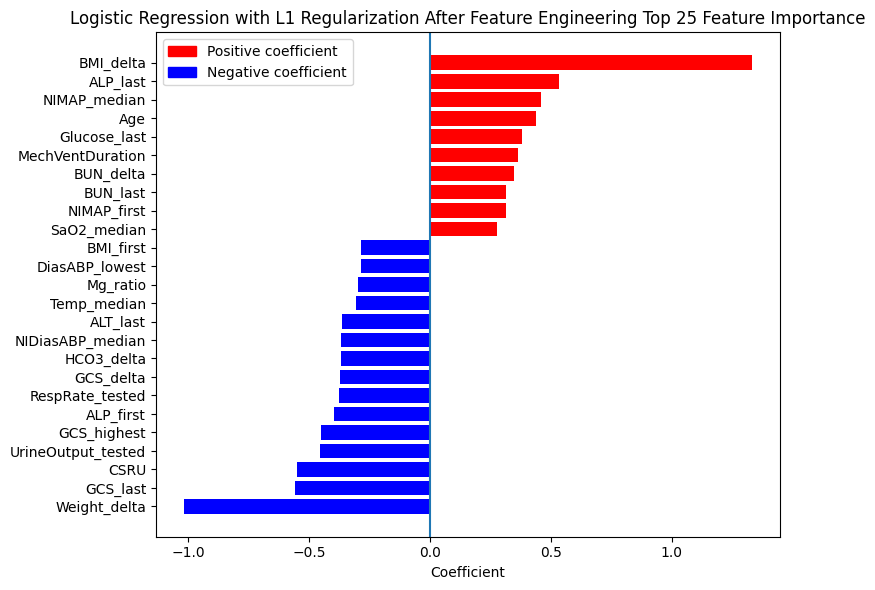

In [ ]:
# Top 25 Features
util.plot_top25_feature_importance(coef_df_m2, model_name='Logistic Regression with L1 Regularization After Feature Engineering')

In [ ]:
# Compare top 25 features before and after feature engineering

coef_df_before=coef_df.sort_values('abs_coef', ascending=False).head(25).rename(columns={'coef':'coef_before','abs_coef':'abs_coef_before'})
coef_df_after=coef_df_m2.sort_values('abs_coef', ascending=False).head(25).rename(columns={'coef':'coef_after','abs_coef':'abs_coef_after'})

top25_features_BeforeAfter=pd.merge(coef_df_before, coef_df_after, on='feature', how='outer')
top25_features_BeforeAfter.sort_values(by=['abs_coef_before','abs_coef_after'], ascending=False)

feature  coef_before  abs_coef_before  coef_after  \
14            GCS_last    -0.805075         0.805075   -0.559058   
7             BUN_last     0.707428         0.707428    0.314601   
8                 CSRU    -0.558133         0.558133   -0.550732   
1             ALP_last     0.545834         0.545834    0.532409   
27        NIMAP_median     0.543042         0.543042    0.457699   
13         GCS_highest    -0.497443         0.497443   -0.449762   
17          HCO3_first     0.476819         0.476819         NaN   
25    NIDiasABP_median    -0.465855         0.465855   -0.366154   
3                  Age     0.443471         0.443471    0.438949   
12           GCS_first     0.439807         0.439807         NaN   
0            ALP_first    -0.382722         0.382722   -0.396214   
15        Glucose_last     0.379485         0.379485    0.379384   
29     RespRate_tested    -0.370374         0.370374   -0.375804   
26         NIMAP_first     0.352900         0.352900    0.312886   
20    MechVentDuration     0.335799         0.335799    0.363899   
18           HCO3_last    -0.319569         0.319569         NaN   
23     NIDiasABP_first    -0.317027         0.317027         NaN   
30         SaO2_median     0.311174         0.311174    0.279044   
31         Temp_median    -0.297930         0.297930   -0.305994   
28            Na_first    -0.286735         0.286735         NaN   
19        Lactate_last     0.283447         0.283447         NaN   
2             ALT_last    -0.280920         0.280920   -0.363399   
10         FiO2_tested     0.280141         0.280141         NaN   
24   NIDiasABP_highest     0.279373         0.279373         NaN   
21     MechVent_tested    -0.276526         0.276526         NaN   
4            BMI_delta          NaN              NaN    1.330057   
33        Weight_delta          NaN              NaN   -1.014789   
32  UrineOutput_tested          NaN              NaN   -0.455054   
11           GCS_delta          NaN              NaN   -0.371027   
16          HCO3_delta          NaN              NaN   -0.366736   
6            BUN_delta          NaN              NaN    0.348379   
22            Mg_ratio          NaN              NaN   -0.297991   
9       DiasABP_lowest          NaN              NaN   -0.285164   
5            BMI_first          NaN              NaN   -0.285089   

    abs_coef_after  
14        0.559058  
7         0.314601  
8         0.550732  
1         0.532409  
27        0.457699  
13        0.449762  
17             NaN  
25        0.366154  
3         0.438949  
12             NaN  
0         0.396214  
15        0.379384  
29        0.375804  
26        0.312886  
20        0.363899  
18             NaN  
23             NaN  
30        0.279044  
31        0.305994  
28             NaN  
19             NaN  
2         0.363399  
10             NaN  
24             NaN  
21             NaN  
4         1.330057  
33        1.014789  
32        0.455054  
11        0.371027  
16        0.366736  
6         0.348379  
22        0.297991  
9         0.285164  
5         0.285089

In [ ]:
coef_df_m2_zero_coef = coef_df_m2[coef_df_m2['coef'] == 0]
print('Number of features with zero coefficients after feature engineering:', coef_df_m2_zero_coef.shape[0])
coef_df_m2_zero_coef_list=coef_df_m2_zero_coef['feature'].sort_values().tolist()

Number of features with zero coefficients after feature engineering: 32


In [ ]:
# Full correlation matrix
corr_matrix=X_train[sorted(X_train.columns)].corr()

# Columns where zero-coef features have |corr| >= 0.8
mask = (
    corr_matrix.loc[coef_df_m2_zero_coef_list, :].gt(0.8).any() |
    corr_matrix.loc[coef_df_m2_zero_coef_list, :].lt(-0.8).any()
)

correlated_features = corr_matrix.loc[coef_df_m2_zero_coef_list, mask]

# Mask weak correlations for cleaner visualization
corr_display = correlated_features.mask(
    (correlated_features < 0.8) & (correlated_features > -0.8)
)

# Heatmap
plt.figure(figsize=(24,12))
sns.heatmap(corr_display.fillna(0), annot=True, cmap='coolwarm', fmt=".1f", center=0, linewidths=0.2, annot_kws={"size":10})
plt.ylabel('Zero-Coefficient Features After Feature Engineering')
plt.title('Zero-Coefficient Features and Their Strong Correlations (>= |0.8|)')
plt.show()


In [ ]:
# Find highly correlated pairs
threshold = 0.8
high_corr_pairs_idx = np.where(np.abs(corr_matrix) > threshold)

# Filter out duplicates and self-correlation
high_corr_pairs = [
    (corr_matrix.index[x], corr_matrix.columns[y], corr_matrix.iloc[x, y])
    for x, y in zip(*high_corr_pairs_idx) if x != y and x < y]

# Convert to DataFrame
high_corr_df = pd.DataFrame(high_corr_pairs, columns=["Feature_1", "Feature_2", "Correlation"])
high_corr_df = high_corr_df.sort_values(by="Correlation", ascending=False).reset_index(drop=True)

In [ ]:
# Merge high correlation pairs with logistic regression coefficients
high_corr_df = high_corr_df.merge(coef_df_m2.rename(columns={'feature': 'Feature_1', 'coef': 'Coef_1', 'abs_coef': 'Abs_Coef_1 '}), on='Feature_1')
high_corr_df = high_corr_df.merge(coef_df_m2.rename(columns={'feature': 'Feature_2', 'coef': 'Coef_2', 'abs_coef': 'Abs_Coef_2 '}), on='Feature_2')
high_corr_df=high_corr_df.sort_values(by='Correlation', ascending=False)
high_corr_df=high_corr_df[['Feature_1','Feature_2','Correlation', 'Coef_1',   'Coef_2' ]].sort_values(['Feature_1','Feature_2'])

In [ ]:
high_corr_df[(high_corr_df.Coef_1==0) | (high_corr_df.Coef_2==0)]

Feature_1                    Feature_2  Correlation    Coef_1  \
12         ALP_tested                   ALT_tested     0.971717  0.000000   
10         ALP_tested                   AST_tested     0.974201  0.000000   
15         ALP_tested             Bilirubin_tested     0.950696  0.000000   
8          ALP_tested  Number_Kidney_Panels_Tested     0.988529  0.000000   
20          ALT_first                    AST_first     0.923638  0.210840   
6          ALT_tested                   AST_tested     0.991100  0.123557   
7          ALT_tested  Number_Kidney_Panels_Tested     0.989740  0.123557   
17         AST_tested             Bilirubin_tested     0.942562  0.000000   
5          AST_tested  Number_Kidney_Panels_Tested     0.991400  0.000000   
14      Albumin_delta                Albumin_ratio     0.951952  0.069542   
27      Albumin_first                 Albumin_last     0.907743 -0.035227   
9           BMI_first                     BMI_last     0.978320 -0.285089   
29          BUN_first                     BUN_last     0.897665  0.000000   
16    Bilirubin_first               Bilirubin_last     0.945559  0.000000   
11   Bilirubin_tested  Number_Kidney_Panels_Tested     0.972101 -0.036521   
26   Creatinine_first              Creatinine_last     0.907814  0.000000   
41    DiasABP_highest                DiasABP_range     0.854623 -0.168323   
59         FiO2_delta                   FiO2_first    -0.843862  0.000000   
13         FiO2_delta                   FiO2_ratio     0.954417  0.000000   
52      Glucose_first              Glucose_highest     0.811228  0.000000   
19    Glucose_highest                Glucose_range     0.937313 -0.107516   
24  NIDiasABP_highest                NIMAP_highest     0.911461  0.086198   
35     NIDiasABP_last                   NIMAP_last     0.879569 -0.026181   
42   NIDiasABP_lowest                 NIMAP_lowest     0.854476  0.000000   
49      NIMAP_highest             NISysABP_highest     0.813860  0.000000   
53         NIMAP_last                NISysABP_last     0.808251  0.000000   
46       NIMAP_lowest              NISysABP_lowest     0.840146  0.000000   
44        NIMAP_range               NISysABP_range     0.844698 -0.191002   
2          Temp_delta                   Temp_ratio     0.998705 -0.027636   
56         Temp_first                   Temp_ratio    -0.801022  0.000000   

      Coef_2  
12  0.123557  
10  0.000000  
15 -0.036521  
8   0.000000  
20  0.000000  
6   0.000000  
7   0.000000  
17 -0.036521  
5   0.000000  
14  0.000000  
27  0.000000  
9   0.000000  
29  0.314601  
16  0.095917  
11  0.000000  
26 -0.140721  
41  0.000000  
59  0.107768  
13  0.000000  
52 -0.107516  
19  0.000000  
24  0.000000  
35  0.000000  
42  0.000000  
49 -0.128198  
53 -0.053937  
46 -0.246516  
44  0.000000  
2   0.000000  
56  0.000000

## Model Summary – Logistic Regression (L1) with Temporal Features

After incorporating temporal features into the L1-regularized logistic regression model, the model shows an improvement in recall for the non-survived class, with:

- **Recall:** 0.77 (117/151)  
- **Precision:** 0.37 (113/316)  
- **Overall accuracy:** 78%  

This is based on the default threshold of 0.5 and represents an improvement over the baseline model with the same architecture.

After tuning the threshold to 0.44, the model achieves:

- **Recall:** 0.79 (120/151)  
- **Precision:** 0.35 (120/347) 
- **Overall accuracy:** 76%  

However, this performance does not exceed the threshold-tuned baseline model, which maintained a slightly higher recall and lower false positive rate.  

### Feature Importance Insights

Reviewing the top 25 features reveals that several temporal features contribute meaningfully to prediction, including:

- `BUN_delta`  
- `BUN_ratio`  
- `GCS_delta`  
- `HCO3_delta`  
- `Mg_ratio`  

Interestingly, `GCS_first`, which was among the top 25 baseline features, is assigned a zero coefficient in the new model. Correlation analysis shows no other features with |r| ≥ 0.8 relative to `GCS_first`, suggesting that the temporal features now provide more predictive signal. This shift likely reflects the imbalanced dataset, where the minority class (non-survived) is small, and temporal features better capture patient deterioration over time.

### Summary

Overall, model performance remains relatively stable compared to the baseline L1 logistic regression. Temporal features add interpretive value and highlight potential multivariate relationships in ICU outcomes. The presence of these temporal dynamics suggests that the underlying relationships may not be fully linear, motivating exploration of decision tree model (Random Forest).



# XGBoost

In [37]:
pos = np.sum(y_train)
neg = len(y_train) - pos
scale_pos_weight = neg / pos

scale_pos_weight

np.float64(6.159090909090909)

In [128]:

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='aucpr',          # better for imbalance
    n_estimators=160,
    learning_rate=0.05,
    max_depth=2,                  # shallow trees
    min_child_weight=10,          # VERY important for small positives
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1,                # L1 regularization
    reg_lambda=2,               # L2 regularization
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
              max_leaves=None, min_child_weight=10, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=160,
              n_jobs=-1, num_parallel_tree=None, ...)

In [129]:
y_prob_test = xgb_model.predict_proba(X_test)[:, 1]
y_prob_train = xgb_model.predict_proba(X_train)[:, 1]

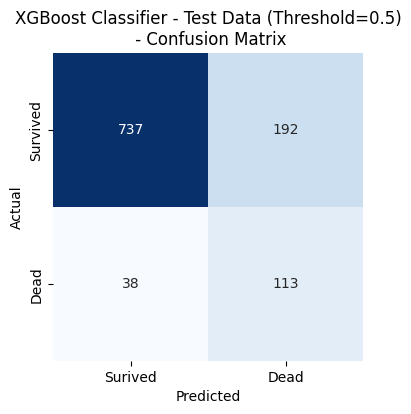

              precision    recall  f1-score   support

           0       0.95      0.79      0.87       929
           1       0.37      0.75      0.50       151

    accuracy                           0.79      1080
   macro avg       0.66      0.77      0.68      1080
weighted avg       0.87      0.79      0.81      1080



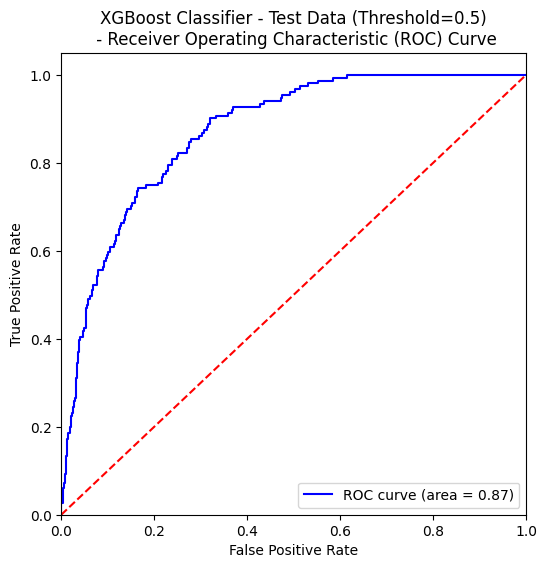

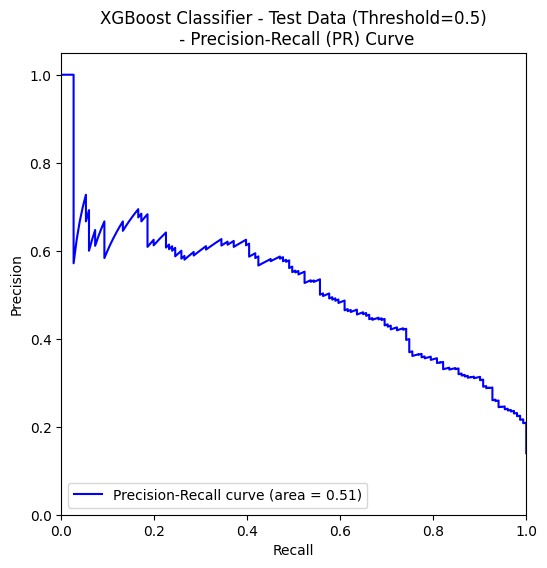

In [130]:
util.evaluate_classification_model(y_prob_test, 0.5, y_test, model_name='XGBoost Classifier - Test Data')

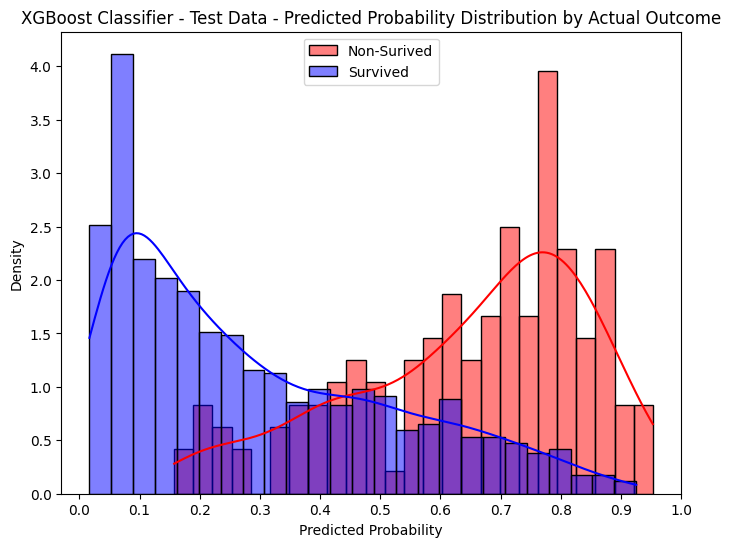

In [131]:
util.plot_threshold_distribution(y_prob_test, y_test, model_name='XGBoost Classifier - Test Data')

In [132]:
util.threshold_analysis(y_prob_test, y_test, threshold_range=np.arange(0.3, 0.725, 0.01))

Threshold 0.300 -> Recall: 0.927, FPR: 0.391, Precisinon: 0.278
Threshold 0.310 -> Recall: 0.927, FPR: 0.385, Precisinon: 0.281
Threshold 0.320 -> Recall: 0.927, FPR: 0.372, Precisinon: 0.288
Threshold 0.330 -> Recall: 0.914, FPR: 0.365, Precisinon: 0.289
Threshold 0.340 -> Recall: 0.907, FPR: 0.349, Precisinon: 0.297
Threshold 0.350 -> Recall: 0.907, FPR: 0.339, Precisinon: 0.303
Threshold 0.360 -> Recall: 0.901, FPR: 0.327, Precisinon: 0.309
Threshold 0.370 -> Recall: 0.887, FPR: 0.319, Precisinon: 0.312
Threshold 0.380 -> Recall: 0.881, FPR: 0.314, Precisinon: 0.313
Threshold 0.390 -> Recall: 0.874, FPR: 0.308, Precisinon: 0.316
Threshold 0.400 -> Recall: 0.861, FPR: 0.300, Precisinon: 0.318
Threshold 0.410 -> Recall: 0.854, FPR: 0.286, Precisinon: 0.327
Threshold 0.420 -> Recall: 0.834, FPR: 0.276, Precisinon: 0.330
Threshold 0.430 -> Recall: 0.828, FPR: 0.270, Precisinon: 0.332
Threshold 0.440 -> Recall: 0.821, FPR: 0.262, Precisinon: 0.338
Threshold 0.450 -> Recall: 0.808, FPR: 0

In [133]:
XGBoost_Selected_Threshold=0.45

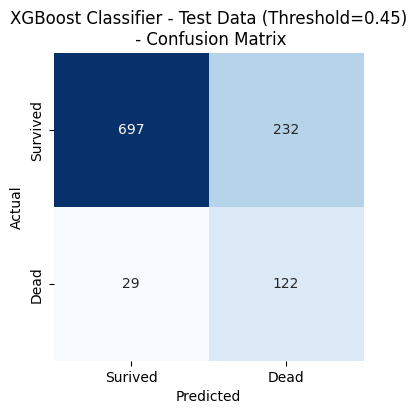

              precision    recall  f1-score   support

           0       0.96      0.75      0.84       929
           1       0.34      0.81      0.48       151

    accuracy                           0.76      1080
   macro avg       0.65      0.78      0.66      1080
weighted avg       0.87      0.76      0.79      1080



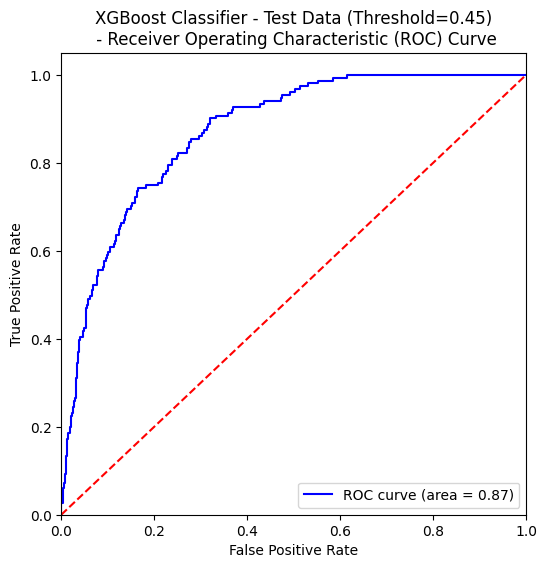

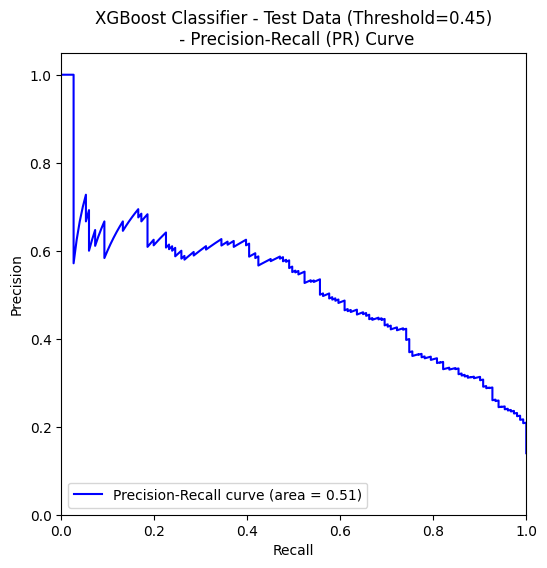

In [134]:
util.evaluate_classification_model(y_prob_test,XGBoost_Selected_Threshold, y_test, model_name='XGBoost Classifier - Test Data') 

## Feature Importances

In [ ]:
xgb_importance_dict = xgb_model.get_booster().get_score(importance_type='gain') # Average gain of splits which use the feature
xgb_importance_df=pd.DataFrame(xgb_importance_dict.items(), columns=['feature', 'gain'])
xgb_importance_df=xgb_importance_df.sort_values(by='gain', ascending=False)

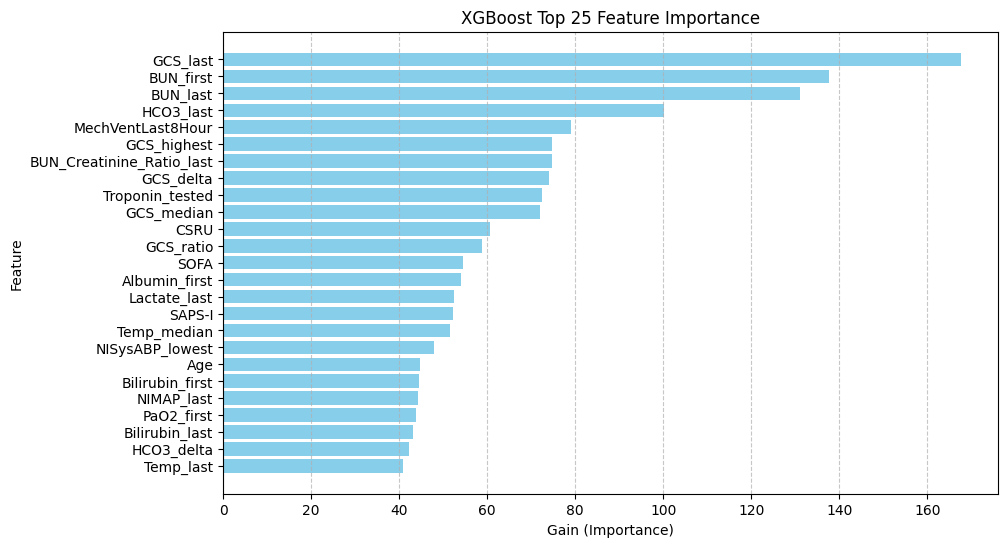

In [ ]:
plt.figure(figsize=(10,6))
plt.barh(
    xgb_importance_df['feature'].head(25),
    xgb_importance_df['gain'].head(25),
    color='skyblue')
plt.title('XGBoost Top 25 Feature Importance')
plt.xlabel('Gain (Importance)')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

## Shap Values

In [ ]:
explainer=shap.TreeExplainer(xgb_model, X_train)
# Compute SHAP values for test set
shap_values_test = explainer(X_test)

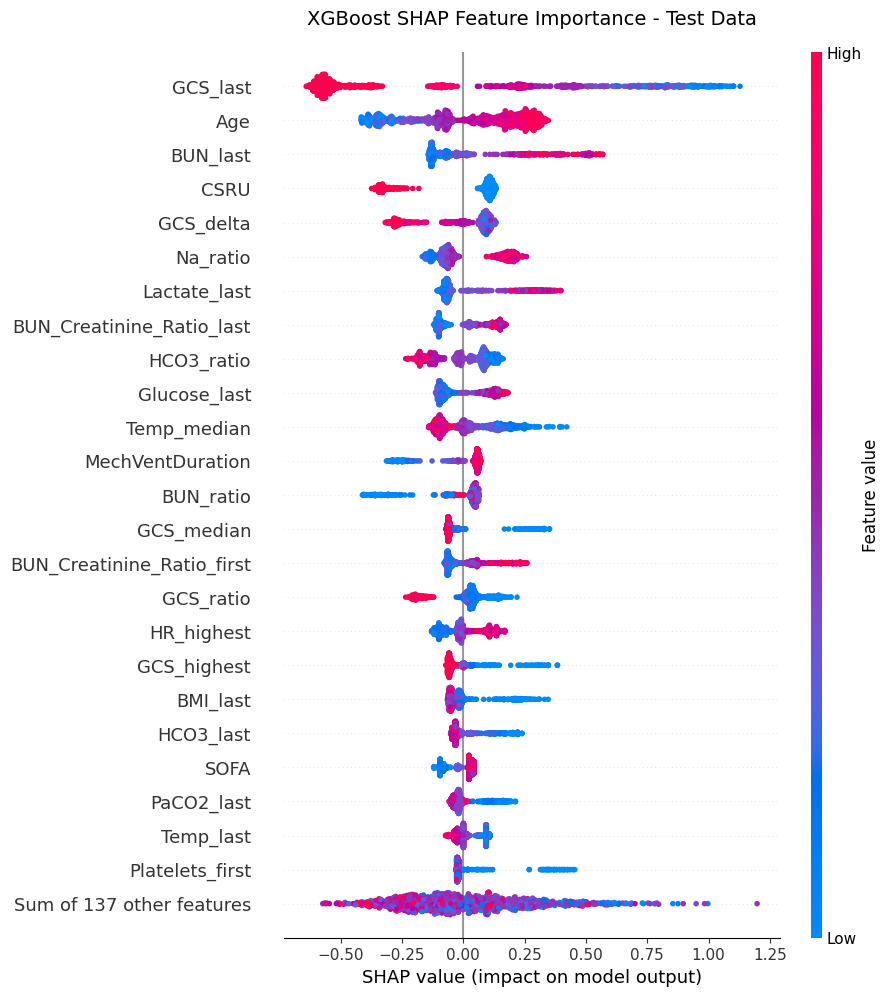

In [ ]:
shap.plots.beeswarm(shap_values_test, max_display=25, show=False)
plt.title('XGBoost SHAP Feature Importance - Test Data', fontsize=14, pad=20)
plt.show()

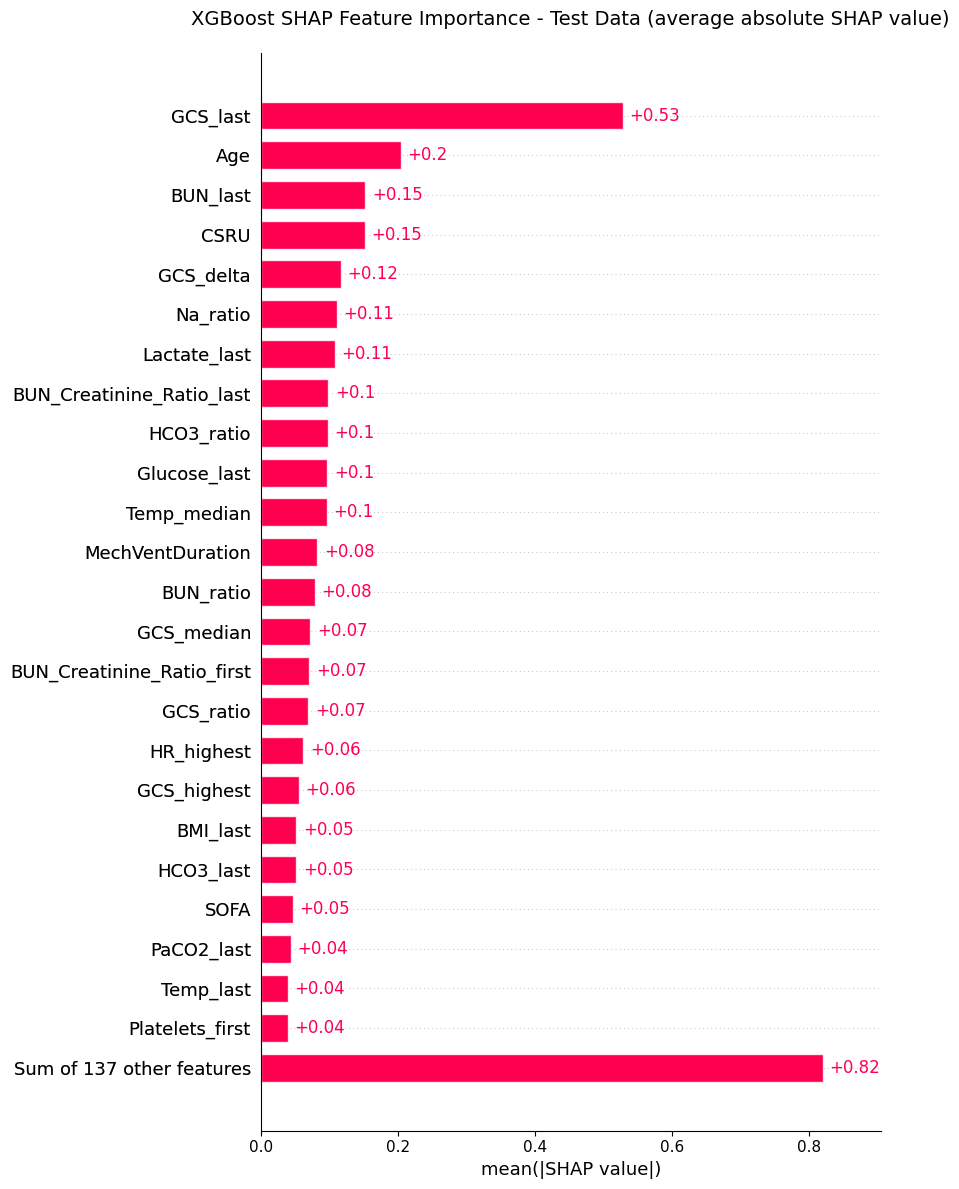

In [ ]:
shap.plots.bar(shap_values_test, max_display=25, show=False)
plt.title('XGBoost SHAP Feature Importance - Test Data (average absolute SHAP value)', fontsize=14, pad=20)
plt.show()

## Decision Trees

<Figure size 2400x1800 with 0 Axes>

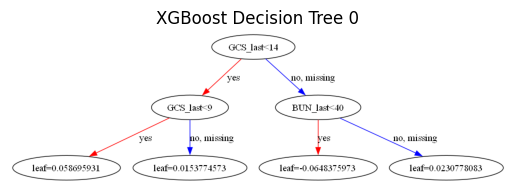

<Figure size 2400x1800 with 0 Axes>

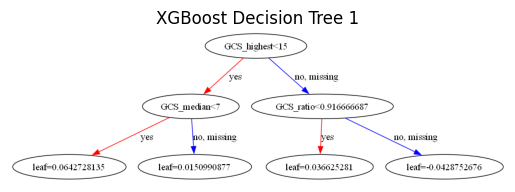

<Figure size 2400x1800 with 0 Axes>

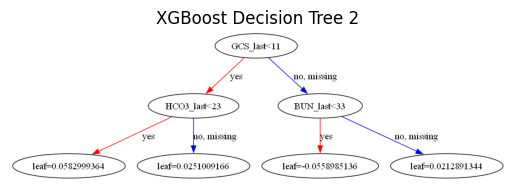

<Figure size 2400x1800 with 0 Axes>

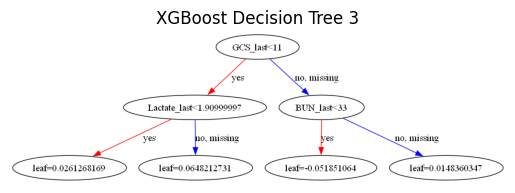

<Figure size 2400x1800 with 0 Axes>

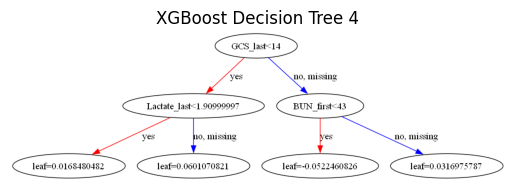

In [ ]:
for i in range(5):
    plt.figure(figsize=(24, 18))
    xgb.plot_tree(xgb_model, num_trees=i, max_depth=2)
    plt.title(f"XGBoost Decision Tree {i}")
    plt.savefig(r'./figures/xgb_tree_'+str(i)+'.png', dpi=800, bbox_inches='tight')   # high-res raster
    plt.show()

## Error Analysis

In [ ]:
y_pred_xgb=(y_prob_test >=0.46).astype(int)
y_pred_xgb
y_pred_xgb=(y_prob_test >=XGBoost_Selected_Threshold).astype(int)

In [ ]:
# Test results dataframe
test_results=pd.DataFrame({'y_true': y_test,'y_pred': y_pred_xgb, 'y_prob': y_prob_test}).reset_index(drop=True)

misclassified_dead=test_results[(test_results['y_true'] ==1) & (test_results['y_pred'] == 0)].index.tolist()
misclassified_surived=test_results[(test_results['y_true'] ==0) & (test_results['y_pred'] == 1)].index.tolist()

791


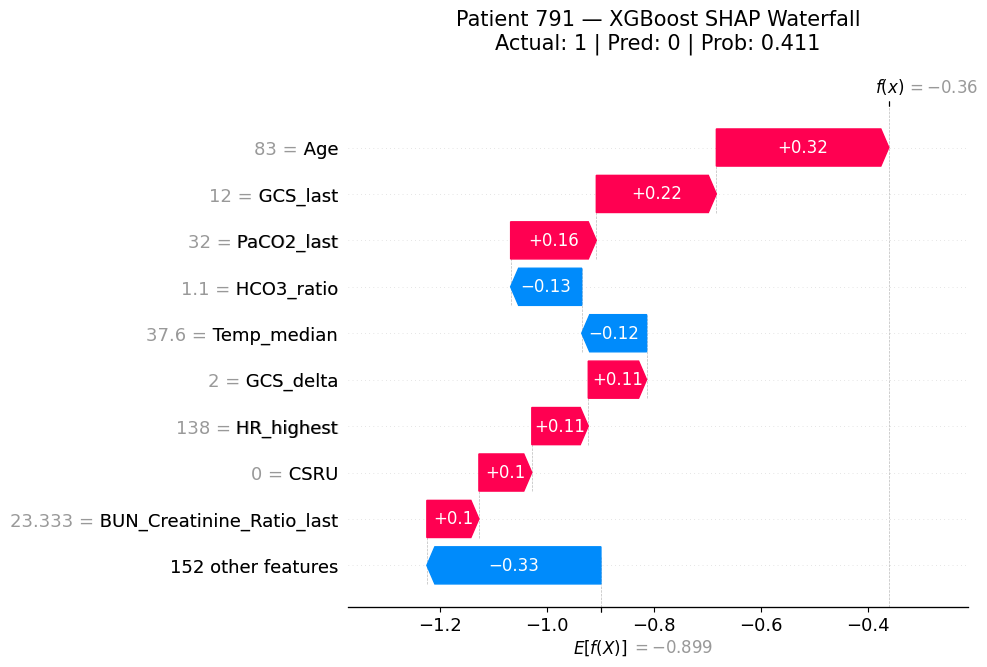

810


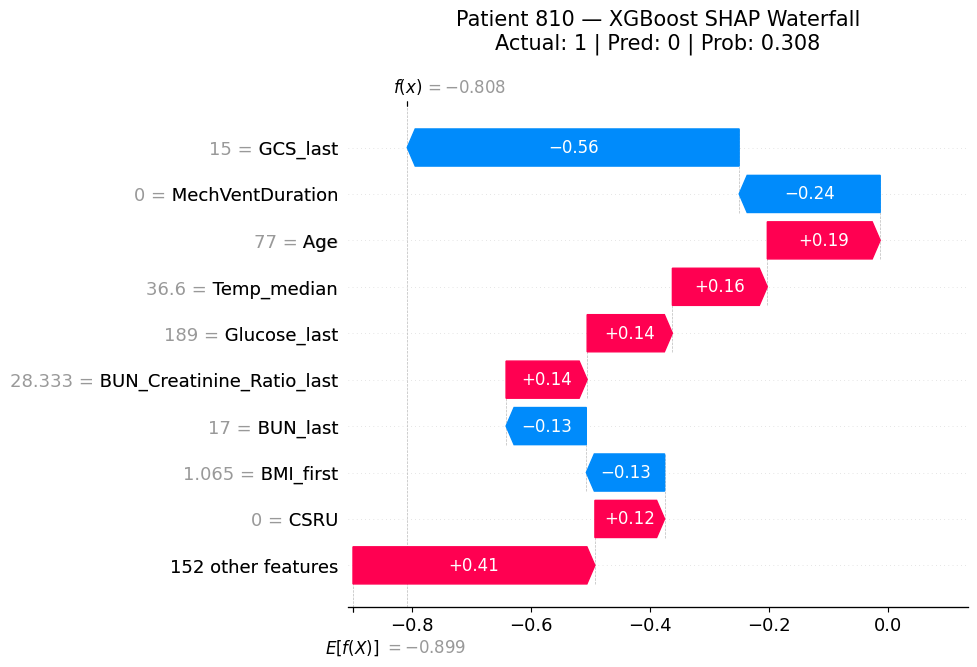

862


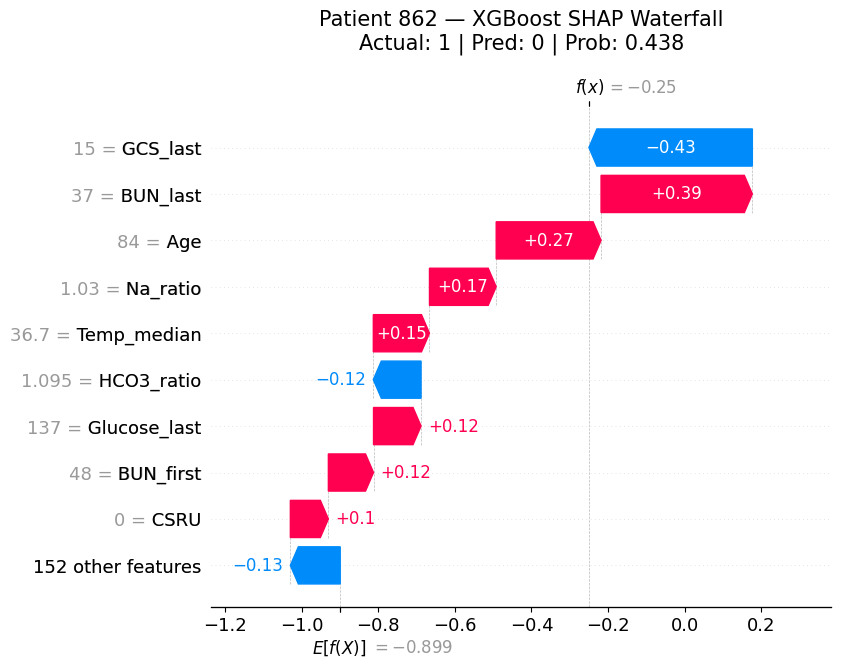

911


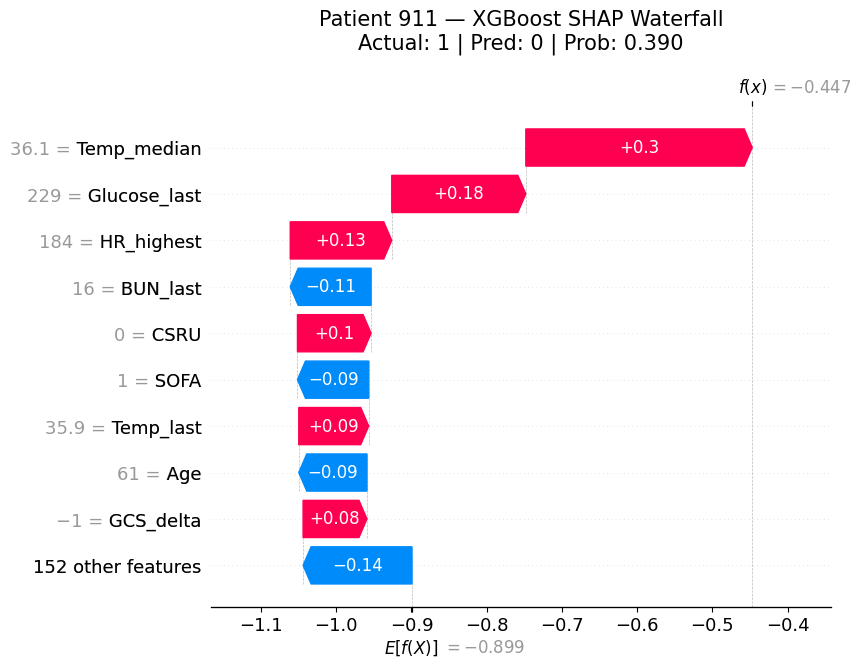

1066


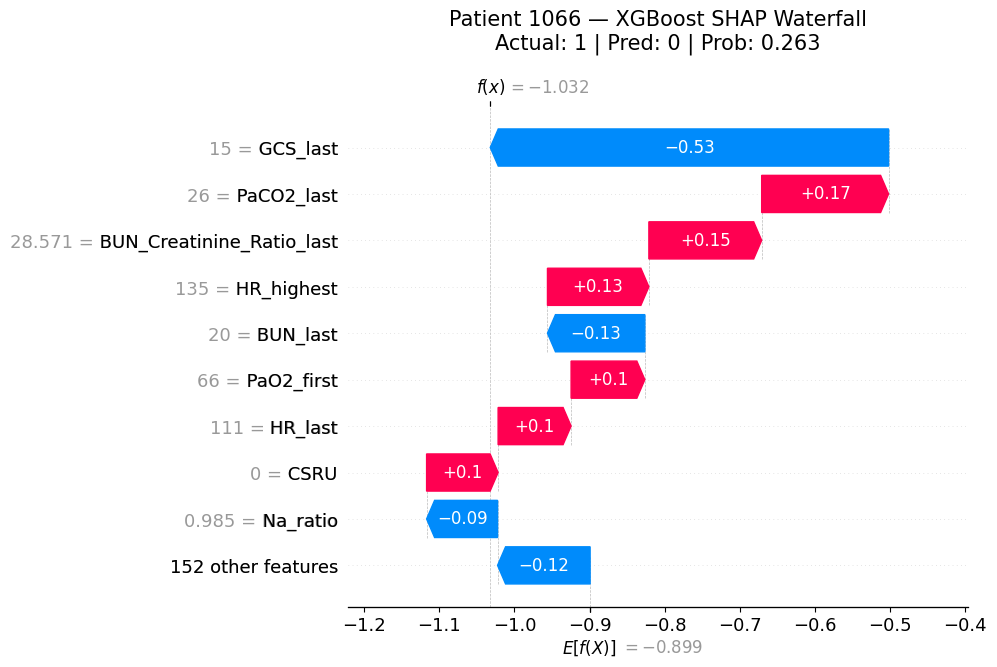

1059


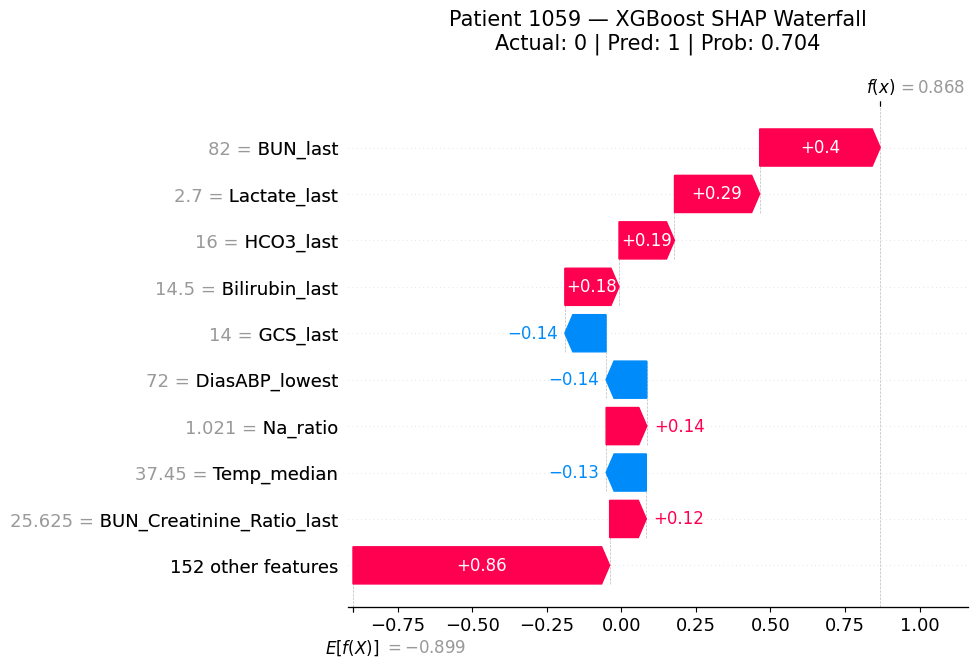

1070


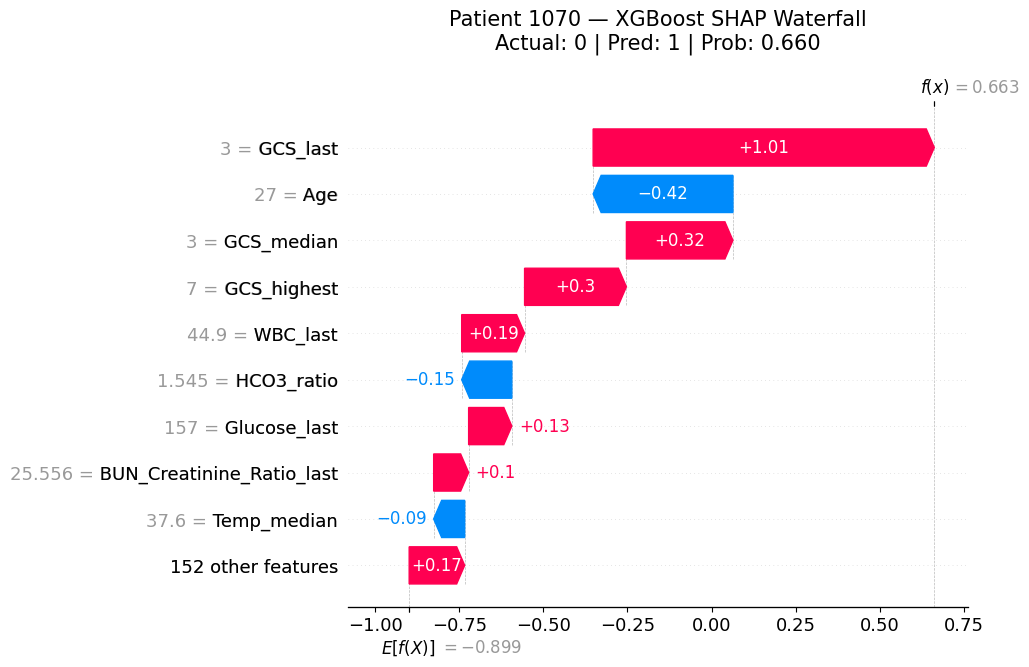

1072


1076


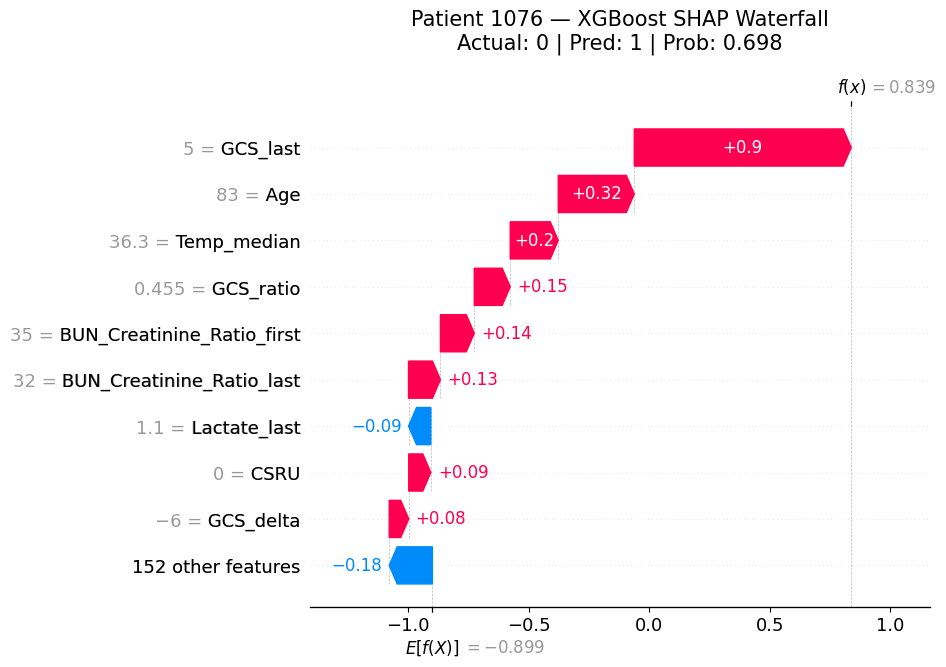

1079


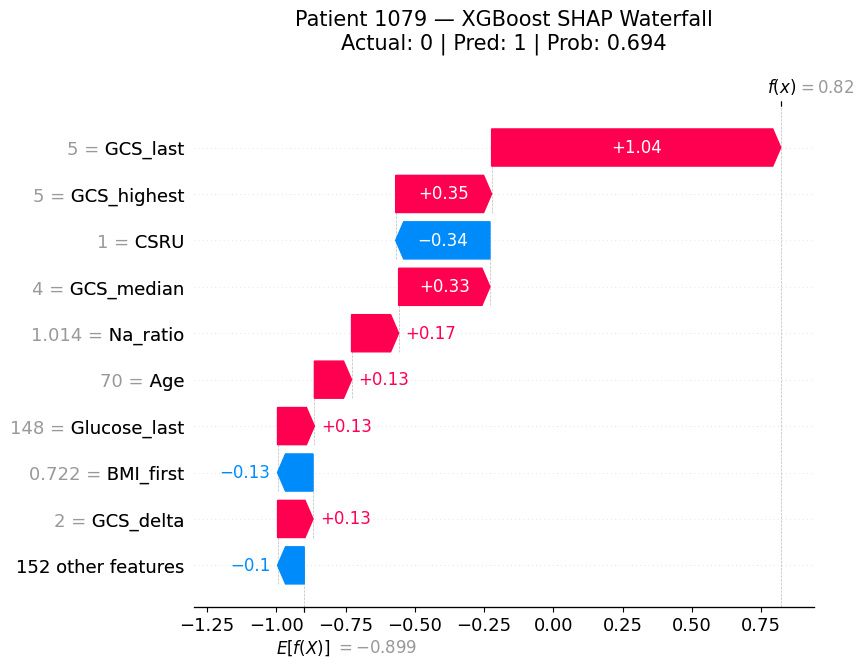

In [ ]:
# Last 5 misclassified dead patients and Last 5 misclassified survived patients
missclassified_list=misclassified_dead[-5:]+misclassified_surived[-5:]

for index_id in missclassified_list:
    print(index_id)
    shap.plots.waterfall(shap_values_test[index_id],show=False)
    plt.title(
        f"Patient {index_id} — XGBoost SHAP Waterfall\n"
        f"Actual: {int(test_results.iloc[index_id]['y_true'])} | "
        f"Pred: {int(test_results.iloc[index_id]['y_pred'])} | "
        f"Prob: {test_results.iloc[index_id]['y_prob']:.3f}",
        fontsize=15,
        pad=20
    )
    plt.show()


## XGBoost Summary

XGboost shows an overall accuracy of 79%, recall at 0.77 (117/151) and a precision of 0.58 (177/305) with the default threshold at 0.5. The results appear to be aligned with the logistic regression L1 regularization models with a decreased of 0.1 in recall from 0.78 (118/151), but a 0.13 increase in precision from 0.37 (118/321). 

By tuning threshold of the XGboost model to 0.45, the overall accuracy has reduced to 77%, but an increased in recall for the mortility patients to 0.83 (126/151), and a decreased in precision to 0.36 (126/353).
